In [1]:
# CELL 01 - Setup (No Repo Clone)
import os
from pathlib import Path
import sys
import subprocess

# Set working directory to /content (Colab default) or current dir
if os.path.exists('/content'):
    os.chdir('/content')
    SAFE_CWD = Path('/content')
else:
    SAFE_CWD = Path.cwd()

print(f"CWD: {Path.cwd()}")

# Install dependencies directly (skipping requirements.txt)
# py-boost: GBDT model
# obonet: GO ontology parsing
# biopython: FASTA parsing (optional but good to have)
# pyyaml: Config parsing (if needed)
pkgs = ['py-boost', 'obonet', 'biopython', 'pyyaml']
print(f"Installing: {', '.join(pkgs)}...")
try:
    subprocess.check_call([sys.executable, '-m', 'pip', '-q', 'install'] + pkgs)
    print("Dependencies installed.")
except subprocess.CalledProcessError as e:
    print(f"Warning: Dependency installation failed: {e}")


CWD: /content
Installing: py-boost, obonet, biopython, pyyaml...
Dependencies installed.


In [2]:
# CELL 02 - Environment Info
import os
import sys

def _detect_kaggle() -> bool:
    return bool(os.environ.get('KAGGLE_KERNEL_RUN_TYPE') or os.environ.get('KAGGLE_URL_BASE') or os.environ.get('KAGGLE_DATA_PROXY_URL'))
def _detect_colab() -> bool:
    return bool(os.environ.get('COLAB_RELEASE_TAG') or os.environ.get('COLAB_GPU') or os.environ.get('COLAB_TPU_ADDR'))

IS_KAGGLE = _detect_kaggle()
IS_COLAB = (not IS_KAGGLE) and _detect_colab()

if IS_KAGGLE:
    print('Environment: Kaggle Detected')
elif IS_COLAB:
    print('Environment: Colab Detected')
else:
    print('Environment: Local Detected')

# Dependencies are now installed in Cell 01.


Environment: Colab Detected


In [3]:
# CELL 02b - Secrets Setup (Colab/Kaggle/Local)
import os
import sys

def get_secret(key):
    # 1. Try Google Colab Userdata (Preferred for Colab)
    try:
        from google.colab import userdata
        return userdata.get(key)
    except ImportError:
        pass
    except Exception:
        pass

    # 2. Try Kaggle Secrets (Preferred for Kaggle)
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        return user_secrets.get_secret(key)
    except ImportError:
        pass
    except Exception:
        pass

    # 3. Try OS Environment (Fallback for Local/Other)
    return os.environ.get(key)

print("=== Configuring Secrets ===")

# Set up KAGGLE_USERNAME and KAGGLE_KEY for API usage
KAGGLE_USERNAME = get_secret('KAGGLE_USERNAME')
KAGGLE_KEY = get_secret('KAGGLE_KEY')

if KAGGLE_USERNAME and KAGGLE_KEY:
    os.environ['KAGGLE_USERNAME'] = KAGGLE_USERNAME
    os.environ['KAGGLE_KEY'] = KAGGLE_KEY
    print(f"SUCCESS: Secrets loaded for user: {KAGGLE_USERNAME}")
else:
    print("WARNING: Kaggle secrets not found. API calls (dataset download) may fail.")
    print("  - On Colab: Add secrets via the 'Secrets' key icon on the left.")
    print("  - On Kaggle: Add secrets via 'Add-ons' -> 'Secrets'.")


=== Configuring Secrets ===
SUCCESS: Secrets loaded for user: peterola


Environment: Colab Detected
DEBUG: Authenticating as Kaggle User: 'peterola'
Unzipping cafa-6-protein-function-prediction.zip...
DATASET_ROOT: /content/cafa6_data
All required inputs found.
FASTA smoke tests:
  Train FASTA: OK
  Test FASTA: OK
CAFA_FORCE_REBUILD (env): '0'
CAFA_FORCE_REBUILD (effective): 0
Kaggle auth present: True
Kaggle username length: 8
Kaggle key length: 32
Checkpoint pull (full via KaggleApi).
Checkpoint dataset files (first 60):
 - README.md
 - cleanup_removed_ankh_npys.txt
 - external/entryid_text.tsv
 - external/prop_test_no_kaggle.tsv
 - external/prop_train_no_kaggle.tsv
 - features/test_embeds_esm2.npy
 - features/test_embeds_esm2_3b.npy
 - features/test_embeds_t5.npy
 - features/test_embeds_text.npy
 - features/text_vectorizer.joblib
 - features/train_embeds_esm2.npy
 - features/train_embeds_esm2_3b.npy
 - features/train_embeds_t5.npy
 - features/train_embeds_text.npy
 - manifest.json
 - parsed/term_counts.parquet
 - parsed/term_priors.parquet
 - parsed/tes

100%|██████████| 5.66G/5.66G [00:18<00:00, 323MB/s]



Extracting relevant files from cafa6-checkpoints.zip...
Extracting 22 files...
Checkpoint status (after pull):
  WORK_ROOT: /content/work
  parsed/: OK (0.0 MB)
  external/: OK (0.0 MB)
  features/: OK (0.0 MB)
  parsed.zip: MISSING
  external.zip: MISSING
  features.zip: MISSING
  external/entryid_text.tsv: OK (680.2 MB)
  parsed/train_seq.feather: OK (42.5 MB)


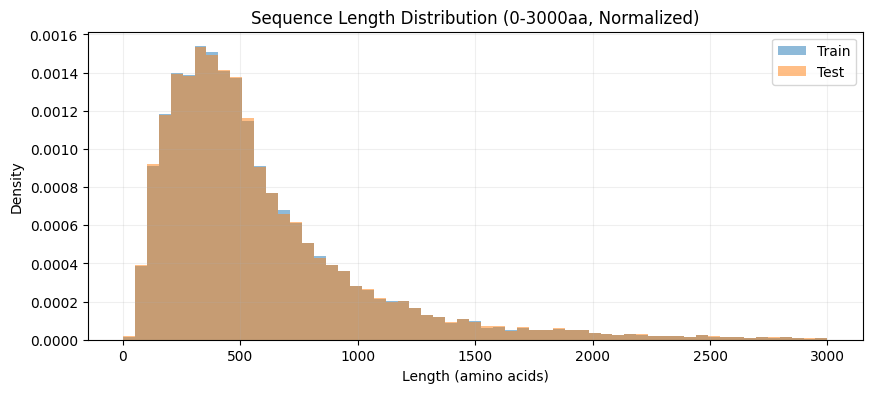

Train sequences: 20001
Test sequences : 20001
Train max len  : 34350
Test max len   : 34350


In [4]:
# CELL 03 - Solution: 1. SETUP, CONFIG & DIAGNOSTICS
# 1. SETUP, CONFIG & DIAGNOSTICS
# ==========================================
# HARDWARE: CPU (Standard)
# ==========================================
import json
import os
import shutil
import subprocess
import sys
import time
import zipfile
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ------------------------------------------
# Environment Detection & Paths
# ------------------------------------------
# Kaggle images can have `google-colab` installed; never use `import google.colab` as a signal.

def _detect_kaggle() -> bool:
    # Kaggle kernels reliably set at least one of these env vars.
    return bool(
        os.environ.get('KAGGLE_KERNEL_RUN_TYPE')
        or os.environ.get('KAGGLE_URL_BASE')
        or os.environ.get('KAGGLE_DATA_PROXY_URL')
    )


def _detect_colab() -> bool:
    # Colab sets these env vars; this avoids false positives on Kaggle.
    return bool(os.environ.get('COLAB_RELEASE_TAG') or os.environ.get('COLAB_GPU') or os.environ.get('COLAB_TPU_ADDR'))


IS_KAGGLE = _detect_kaggle()
IS_COLAB = (not IS_KAGGLE) and _detect_colab()

if IS_KAGGLE:
    print('Environment: Kaggle Detected')
    INPUT_ROOT = Path('/kaggle/input')
    WORKING_ROOT = Path('/kaggle/working')
    if INPUT_ROOT.exists():
        for dirname, _, filenames in os.walk(str(INPUT_ROOT)):
            for filename in filenames:
                print(os.path.join(dirname, filename))
elif IS_COLAB:
    print('Environment: Colab Detected')
    INPUT_ROOT = Path(os.environ.get('CAFA_INPUT_ROOT', str(Path('/content'))))
    WORKING_ROOT = Path(os.environ.get('CAFA_WORKING_ROOT', str(Path('/content'))))
else:
    print('Environment: Local Detected')
    CURRENT_DIR = Path.cwd()
    if CURRENT_DIR.name == 'notebooks':
        PROJECT_ROOT = CURRENT_DIR.parent
    else:
        PROJECT_ROOT = CURRENT_DIR
    INPUT_ROOT = Path(os.environ.get('CAFA_INPUT_ROOT', str(PROJECT_ROOT)))
    WORKING_ROOT = Path(os.environ.get('CAFA_WORKING_ROOT', str(PROJECT_ROOT / 'artefacts_local')))
    WORKING_ROOT.mkdir(exist_ok=True)

# ------------------------------------------
# Local cache roots (ephemeral) + published artefacts root
# ------------------------------------------
# IMPORTANT: we always write locally first (every runtime needs a write path),
# but the Kaggle Dataset is the *single source of truth* for resumability.

WORK_ROOT = Path(os.environ.get('CAFA_WORK_ROOT', str(WORKING_ROOT / 'work')))
WORK_ROOT.mkdir(parents=True, exist_ok=True)
(WORK_ROOT / 'parsed').mkdir(parents=True, exist_ok=True)
(WORK_ROOT / 'features').mkdir(parents=True, exist_ok=True)
(WORK_ROOT / 'external').mkdir(parents=True, exist_ok=True)

# Keep caches OUT of WORK_ROOT so we never accidentally publish them.
CACHE_ROOT = Path(os.environ.get('CAFA_CACHE_ROOT', str(WORKING_ROOT / 'cache')))
CACHE_ROOT.mkdir(parents=True, exist_ok=True)
os.environ.setdefault('HF_HOME', str(CACHE_ROOT / 'hf_home'))
os.environ.setdefault('TRANSFORMERS_CACHE', str(CACHE_ROOT / 'hf_home'))
os.environ.setdefault('HF_HUB_CACHE', str(CACHE_ROOT / 'hf_hub'))
os.environ.setdefault('TORCH_HOME', str(CACHE_ROOT / 'torch_home'))

# ------------------------------------------
# Dataset Discovery (competition data)
# ------------------------------------------

DATASET_SLUG = 'cafa-6-protein-function-prediction'


def _score_dataset_dir(p: Path) -> int:
    return (
        int((p / 'Train').exists())
        + int((p / 'Test').exists())
        + int((p / 'IA.tsv').exists())
        + int((p / 'sample_submission.tsv').exists())
    )


def find_dataset_root(input_root: Path, dataset_slug: str) -> Path:
    override = (os.environ.get('CAFA_DATASET_ROOT') or '').strip()
    if override:
        p = Path(override)
        if p.exists():
            return p
        raise FileNotFoundError(f'CAFA_DATASET_ROOT is set but does not exist: {p}')

    candidate = input_root / dataset_slug
    if candidate.exists() and _score_dataset_dir(candidate) >= 2:
        return candidate

    if _score_dataset_dir(input_root) >= 2:
        return input_root

    # Shallow scan: input_root/* and input_root/*/* (helps Colab + GitHub clones)
    candidates: list[Path] = []
    if input_root.exists():
        for p in input_root.iterdir():
            if not p.is_dir():
                continue
            candidates.append(p)
            try:
                for q in p.iterdir():
                    if q.is_dir():
                        candidates.append(q)
            except Exception:
                pass

    candidates = sorted(set(candidates), key=_score_dataset_dir, reverse=True)
    if candidates and _score_dataset_dir(candidates[0]) >= 2:
        return candidates[0]

    auto_flag = (os.environ.get('CAFA_COLAB_AUTO_DOWNLOAD') or '').strip() or '<unset>'

    # Colab rule: secrets must be fetched ONLY via google.colab.userdata.get(...)
    if IS_COLAB:
        try:
            from google.colab import userdata  # type: ignore

            has_user = bool((userdata.get('KAGGLE_USERNAME') or '').strip())
            has_key = bool((userdata.get('KAGGLE_KEY') or '').strip())
        except Exception:
            has_user = False
            has_key = False
    else:
        has_user = bool((os.environ.get('KAGGLE_USERNAME') or '').strip())
        has_key = bool((os.environ.get('KAGGLE_KEY') or '').strip())

    raise FileNotFoundError(
        f'Dataset not found under {input_root}. '
        'Note: a GitHub clone does not include the CAFA competition files.\n'
        f'CAFA_COLAB_AUTO_DOWNLOAD={auto_flag}; Kaggle creds present={has_user and has_key}.\n'
        'Fix options:\n'
        '  1) Set CAFA_DATASET_ROOT to a folder containing Train/ and Test/ (e.g. Drive).\n'
        '  2) (Colab) Set Colab secrets KAGGLE_USERNAME and KAGGLE_KEY, then set CAFA_COLAB_AUTO_DOWNLOAD=1.'
    )


def _maybe_colab_auto_download_competition() -> None:
    if not IS_COLAB:
        return

    # Default-on in Colab.
    # - Disable by explicitly setting CAFA_COLAB_AUTO_DOWNLOAD=0.
    os.environ.setdefault('CAFA_COLAB_AUTO_DOWNLOAD', '1')

    flag = (os.environ.get('CAFA_COLAB_AUTO_DOWNLOAD') or '').strip()
    if flag == '0':
        print('Colab auto-download disabled (CAFA_COLAB_AUTO_DOWNLOAD=0).')
        return

    target_dir = Path(os.environ.get('CAFA_COLAB_DATA_DIR', str(Path('/content/cafa6_data'))))
    target_dir.mkdir(parents=True, exist_ok=True)
    if _score_dataset_dir(target_dir) >= 2:
        os.environ['CAFA_DATASET_ROOT'] = str(target_dir)
        return

    # Install kaggle CLI if missing
    try:
        subprocess.run(['kaggle', '--version'], check=True, capture_output=True, text=True)
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', '-q', 'install', 'kaggle'])

    # Colab rule: fetch secrets ONLY via google.colab.userdata.get(...)
    try:
        from google.colab import userdata  # type: ignore
    except Exception as e:
        raise RuntimeError('Colab detected but google.colab.userdata is unavailable.') from e

    username = (userdata.get('KAGGLE_USERNAME') or '').strip()
    key = (userdata.get('KAGGLE_KEY') or '').strip()

    print(f"DEBUG: Authenticating as Kaggle User: '{username}'")

    if (not username) or (not key):
        raise RuntimeError(
            'CAFA_COLAB_AUTO_DOWNLOAD=1 but Kaggle API auth is missing. '
            'Set Colab secrets KAGGLE_USERNAME and KAGGLE_KEY.'
        )

    # Export into env for downstream subprocesses (but do NOT *source* from env in Colab).
    os.environ['KAGGLE_USERNAME'] = username
    os.environ['KAGGLE_KEY'] = key
    env = os.environ.copy()

    print(f'Downloading competition data to {target_dir} via Kaggle API...')
    # Do NOT rely on kaggle --unzip; unzip ourselves.
    p = subprocess.run(
        ['kaggle', 'competitions', 'download', '-c', DATASET_SLUG, '-p', str(target_dir)],
        text=True,
        capture_output=True,
        env=env,
    )
    if p.returncode != 0:
        print(p.stdout)
        print(p.stderr)
        raise RuntimeError(
            'Failed to download competition data. See logs above (you may need to accept the competition rules).'
        )

    for z in target_dir.glob('*.zip'):
        try:
            print(f'Unzipping {z.name}...')
            with zipfile.ZipFile(z, 'r') as zf:
                zf.extractall(target_dir)
            z.unlink()
        except Exception as e:
            print(f'Warning: failed to unzip {z}: {e}')

    os.environ['CAFA_DATASET_ROOT'] = str(target_dir)


_maybe_colab_auto_download_competition()

DATASET_ROOT = find_dataset_root(INPUT_ROOT, DATASET_SLUG)
print(f'DATASET_ROOT: {DATASET_ROOT}')

# Define input paths
PATH_IA = DATASET_ROOT / 'IA.tsv'
PATH_SAMPLE_SUB = DATASET_ROOT / 'sample_submission.tsv'
PATH_TRAIN_FASTA = DATASET_ROOT / 'Train' / 'train_sequences.fasta'
PATH_TRAIN_TERMS = DATASET_ROOT / 'Train' / 'train_terms.tsv'
PATH_TRAIN_TAXON = DATASET_ROOT / 'Train' / 'train_taxonomy.tsv'
PATH_GO_OBO = DATASET_ROOT / 'Train' / 'go-basic.obo'
PATH_TEST_FASTA = DATASET_ROOT / 'Test' / 'testsuperset.fasta'
PATH_TEST_TAXON = DATASET_ROOT / 'Test' / 'testsuperset-taxon-list.tsv'

# ------------------------------------------
# Sanity Checks
# ------------------------------------------

required = {
    'IA.tsv': PATH_IA,
    'Train/train_sequences.fasta': PATH_TRAIN_FASTA,
    'Train/train_terms.tsv': PATH_TRAIN_TERMS,
    'Train/go-basic.obo': PATH_GO_OBO,
}
missing = {k: v for k, v in required.items() if not v.exists()}
if missing:
    raise FileNotFoundError(f'Missing files: {missing}')
print('All required inputs found.')

# ------------------------------------------
# Fail-fast: FASTA readability checks (path issues)
# ------------------------------------------

def _fasta_smoke_test(path: Path, label: str, max_lines: int = 20000) -> None:
    path = Path(path)

    if not path.exists():
        raise FileNotFoundError(
            f"{label} FASTA not found: {path}\n"
            f"DATASET_ROOT={DATASET_ROOT}\n"
            "If you're on Colab, ensure the competition data downloaded/unzipped correctly,\n"
            "or set CAFA_DATASET_ROOT to the folder containing Train/ and Test/."
        )

    try:
        size = path.stat().st_size
    except Exception:
        size = None

    if size is not None and size == 0:
        raise RuntimeError(f"{label} FASTA file is empty (0 bytes): {path}")

    headers = 0
    first_nonempty = None
    try:
        with path.open('r', encoding='utf-8', errors='ignore') as f:
            for i, line in enumerate(f):
                s = line.strip()
                if not s:
                    continue
                if first_nonempty is None:
                    first_nonempty = s
                if s.startswith('>'):
                    headers += 1
                if i >= max_lines:
                    break
    except Exception as e:
        raise RuntimeError(f"Failed reading {label} FASTA at {path}: {type(e).__name__}: {e}")

    if first_nonempty is None:
        raise RuntimeError(f"{label} FASTA appears empty/unreadable (no non-empty lines): {path}")

    if not first_nonempty.startswith('>'):
        raise RuntimeError(
            f"{label} FASTA does not look like FASTA (first content line doesn't start with '>'): {path}\n"
            f"First line was: {first_nonempty[:120]!r}"
        )

    if headers == 0:
        raise RuntimeError(f"{label} FASTA had zero headers in the first {max_lines} lines: {path}")


print('FASTA smoke tests:')
_fasta_smoke_test(PATH_TRAIN_FASTA, 'Train')
print('  Train FASTA: OK')

if PATH_TEST_FASTA.exists():
    _fasta_smoke_test(PATH_TEST_FASTA, 'Test')
    print('  Test FASTA: OK')
else:
    print(f'  Test FASTA: MISSING at {PATH_TEST_FASTA} (continuing; some steps may fail later)')

# ------------------------------------------
# Checkpoint store (Kaggle Dataset = single source of truth)
# ------------------------------------------

def _get_secret(name: str) -> str:
    # Colab rule: secrets must be fetched ONLY via google.colab.userdata.get(...).
    if IS_COLAB:
        try:
            from google.colab import userdata  # type: ignore

            return (userdata.get(name) or '').strip()
        except Exception:
            return ''

    # Non-Colab: allow env var -> Kaggle Secrets.
    v = (os.environ.get(name, '') or '').strip()
    if v:
        return v

    try:
        from kaggle_secrets import UserSecretsClient  # type: ignore

        v = (UserSecretsClient().get_secret(name) or '').strip()
        if v:
            return v
    except Exception:
        pass

    return ''


# Kaggle Secrets are NOT automatically environment variables.
# Resolve CAFA_FORCE_REBUILD via the same secret lookup and export it so later cells
# (which use os.getenv) behave consistently.
_raw_force_rebuild = (_get_secret('CAFA_FORCE_REBUILD') or '').strip()
if _raw_force_rebuild:
    os.environ.setdefault('CAFA_FORCE_REBUILD', _raw_force_rebuild)


def _truthy(v: str) -> bool:
    return str(v).strip().lower() in {'1', 'true', 'yes', 'y'}


print('CAFA_FORCE_REBUILD (env):', repr(os.environ.get('CAFA_FORCE_REBUILD', '')))
print('CAFA_FORCE_REBUILD (effective):', int(_truthy(os.environ.get('CAFA_FORCE_REBUILD', '0'))))


CHECKPOINT_DATASET_ID = (
    _get_secret('CAFA_CHECKPOINT_DATASET_ID')
    or _get_secret('CAFA_KAGGLE_DATASET_ID')
)
CHECKPOINT_DATASET_TITLE = os.environ.get('CAFA_CHECKPOINT_DATASET_TITLE', 'CAFA6 Checkpoints').strip()
CHECKPOINT_PULL = os.environ.get('CAFA_CHECKPOINT_PULL', '1').strip() == '1'
CHECKPOINT_PUSH = os.environ.get('CAFA_CHECKPOINT_PUSH', '1').strip() == '1'
MANIFEST_PATH = WORK_ROOT / 'manifest.json'


def _get_kaggle_token() -> str:
    return _get_secret('KAGGLE_API_TOKEN')


def _get_kaggle_user_key() -> tuple[str, str]:
    # Kaggle CLI expects Kaggle API credentials: username + key.
    username = _get_secret('KAGGLE_USERNAME')
    key = _get_secret('KAGGLE_KEY')
    if username and key:
        return username, key

    # Back-compat: allow KAGGLE_API_TOKEN to carry either JSON ({username,key}) or 'username:key'.
    tok = _get_kaggle_token()
    if tok:
        try:
            obj = json.loads(tok)
            username = (obj.get('username') or '').strip()
            key = (obj.get('key') or '').strip()
            if username and key:
                return username, key
        except Exception:
            pass

        if ':' in tok:
            u, k = tok.split(':', 1)
            username = u.strip()
            key = k.strip()
            if username and key:
                return username, key

    return '', ''


def _kaggle_env(require: bool = False) -> dict[str, str]:
    env = os.environ.copy()
    username, key = _get_kaggle_user_key()
    if username and key:
        # Export into both subprocess env (this call) and process env (subsequent cells).
        env['KAGGLE_USERNAME'] = username
        env['KAGGLE_KEY'] = key
        os.environ['KAGGLE_USERNAME'] = username
        os.environ['KAGGLE_KEY'] = key

    if require and (not env.get('KAGGLE_USERNAME') or not env.get('KAGGLE_KEY')):
        raise RuntimeError(
            'Kaggle API auth missing. The `kaggle` CLI requires `KAGGLE_USERNAME` + `KAGGLE_KEY` '
            '(set them as env vars or Kaggle/Colab secrets). Or attach the '
            'checkpoint dataset as an Input so `STORE.pull()` can use the mounted copy.'
        )

    return env


def _ensure_kaggle_cli() -> None:
    try:
        subprocess.run(['kaggle', '--version'], check=True, capture_output=True, text=True)
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', '-q', 'install', 'kaggle'])
        subprocess.run(['kaggle', '--version'], check=True)


def _copy_merge(src: Path, dst: Path) -> None:
    src = Path(src)
    dst = Path(dst)

    for p in src.rglob('*'):
        if p.is_dir():
            continue
        rel = p.relative_to(src)
        out = dst / rel
        out.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(p, out)


def _maybe_unpack_dir_mode_zips(work_root: Path) -> None:
    # Kaggle CLI with `--dir-mode zip` uploads directories as `parsed.zip`, `external.zip`, etc.
    # We unpack them back into folders so the pipeline can resume from `WORK_ROOT/{parsed,external,features}/...`.
    work_root = Path(work_root)
    for name in ['parsed', 'external', 'features']:
        zpath = work_root / f'{name}.zip'
        if not zpath.exists():
            continue

        target_dir = work_root / name
        target_dir.mkdir(parents=True, exist_ok=True)
        needs_unpack = (not any(target_dir.rglob('*')))
        if not needs_unpack:
            # Folder already populated; keep the zip as-is (it might be a newer version).
            continue

        print(f'Unpacking checkpoint archive: {zpath} -> {target_dir}')
        with zipfile.ZipFile(zpath, 'r') as zf:
            zf.extractall(target_dir)
        try:
            zpath.unlink()
        except Exception:
            pass


def _load_manifest() -> dict:
    if MANIFEST_PATH.exists():
        try:
            return json.loads(MANIFEST_PATH.read_text(encoding='utf-8'))
        except Exception:
            return {}
    return {}


def _update_manifest(stage: str, required_paths: list[Path], note: str = '') -> None:
    m = _load_manifest()
    stages = m.get('stages', {})
    files = []

    for p in required_paths:
        p = Path(p)
        rel = str(p.relative_to(WORK_ROOT)) if str(p).startswith(str(WORK_ROOT)) else str(p)
        files.append({'path': rel, 'bytes': int(p.stat().st_size) if p.exists() else None})

    stages[stage] = {
        'ts_utc': time.strftime('%Y-%m-%dT%H:%M:%SZ', time.gmtime()),
        'note': note,
        'files': files,
    }

    m['stages'] = stages
    MANIFEST_PATH.write_text(json.dumps(m, indent=2), encoding='utf-8')


def _stage_files_signature(required_paths: list[Path]) -> list[dict]:
    sig = []
    for p in required_paths:
        p = Path(p)
        rel = str(p.relative_to(WORK_ROOT)) if str(p).startswith(str(WORK_ROOT)) else str(p)
        sig.append({'path': rel, 'bytes': int(p.stat().st_size) if p.exists() else None})
    return sorted(sig, key=lambda x: x['path'])


@dataclass
class KaggleCheckpointStore:
    work_root: Path
    dataset_id: str
    dataset_title: str
    pull_enabled: bool
    push_enabled: bool
    input_root: Path
    is_kaggle: bool

    @property
    def mount_dir(self) -> Path | None:
        if not self.is_kaggle or not self.dataset_id:
            return None
        slug = self.dataset_id.split('/')[-1]
        p = self.input_root / slug
        return p if p.exists() else None

    def pull(self) -> None:
        if not self.pull_enabled:
            print('Checkpoint pull disabled (CAFA_CHECKPOINT_PULL=0).')
            return

        checkpoint_required = str(os.environ.get('CAFA_CHECKPOINT_REQUIRED', '1')).strip().lower() in {'1', 'true', 'yes'}
        if not self.dataset_id:
            msg = 'Missing CAFA_CHECKPOINT_DATASET_ID=<user>/<slug>; cannot resume.'
            if checkpoint_required:
                raise ValueError(msg)
            print('WARNING: ' + msg)
            return

        if self.mount_dir is not None:
            print(f'Pulling checkpoints from Kaggle mounted dataset: {self.mount_dir}')
            _copy_merge(self.mount_dir, self.work_root)
            _maybe_unpack_dir_mode_zips(self.work_root)
            return

        print(f'Downloading checkpoints from Kaggle API: {self.dataset_id}')
        _ensure_kaggle_cli()
        env = _kaggle_env(require=checkpoint_required)

        if not env.get('KAGGLE_USERNAME') or not env.get('KAGGLE_KEY'):
            msg = (
                'Kaggle API auth missing. The `kaggle` CLI requires `KAGGLE_USERNAME` + `KAGGLE_KEY` '
                '(set them as env vars or Kaggle/Colab secrets). Either set them, or attach the '
                'checkpoint dataset as a Notebook Input so `STORE.pull()` can use the mounted copy.'
            )
            if checkpoint_required:
                raise RuntimeError(msg)
            print('WARNING: ' + msg)
            return

        tmp = self.work_root / '_tmp_kaggle_download'
        if tmp.exists():
            shutil.rmtree(tmp)
        tmp.mkdir(parents=True, exist_ok=True)

        # Debug (no secrets): confirm auth is present before calling kaggle.
        print('Kaggle auth present:', bool(env.get('KAGGLE_USERNAME')) and bool(env.get('KAGGLE_KEY')))
        print('Kaggle username length:', len(env.get('KAGGLE_USERNAME', '')))
        print('Kaggle key length:', len(env.get('KAGGLE_KEY', '')))

        # Colab can SIGKILL big unzip steps (returncode -9). Avoid `--unzip` and unzip ourselves.
        pull_files_raw = (os.environ.get('CAFA_CHECKPOINT_PULL_FILES') or '').strip()
        pull_files = [f.strip() for f in pull_files_raw.split(',') if f.strip()] if pull_files_raw else []

        def _download_via_kaggle_api(files: list[str] | None) -> tuple[int, str, str]:
            # Use the Kaggle Python API in Colab (more stable than spawning the CLI for large downloads).
            try:
                from kaggle.api.kaggle_api_extended import KaggleApi  # type: ignore
            except Exception as e:
                return 1, '', f'Failed to import KaggleApi: {type(e).__name__}: {e}'

            try:
                api = KaggleApi()
                api.authenticate()
            except Exception as e:
                return 1, '', f'KaggleApi.authenticate() failed: {type(e).__name__}: {e}'

            def _list_dataset_files() -> list[str]:
                try:
                    lf = api.dataset_list_files(self.dataset_id)
                    out = []
                    for f in getattr(lf, 'files', []) or []:
                        name = getattr(f, 'name', None)
                        if name:
                            out.append(str(name))
                    return sorted(out)
                except Exception as e:
                    print('WARNING: failed to list dataset files via KaggleApi:', type(e).__name__, str(e)[:200])
                    return []

            available = _list_dataset_files()
            if available:
                print('Checkpoint dataset files (first 60):')
                for n in available[:60]:
                    print(' -', n)
                if len(available) > 60:
                    print(f' - ... ({len(available)-60} more)')
            else:
                print('WARNING: could not list files for dataset via KaggleApi (might be private/not visible).')

            # Strategy: Force FULL DATASET DOWNLOAD (skipping individual files)
            print('Forcing FULL DATASET DOWNLOAD (skipping individual files)...')

            # Track what we need to extract
            needed_prefixes = set()
            if not files:
                needed_prefixes.add('') # Root
            else:
                for f in files:
                    if f.endswith('.zip'):
                        needed_prefixes.add(f[:-4] + '/') # parsed.zip -> parsed/
                    else:
                        needed_prefixes.add(f) # literal file

            try:
                # Download full zip
                api.dataset_download_files(self.dataset_id, path=str(tmp), force=True, quiet=False, unzip=False)

                # Find the zip
                zips = list(tmp.glob('*.zip'))
                if not zips:
                    return 1, '', 'Full download finished but no .zip file found.'

                main_zip = zips[0]
                print(f'Extracting relevant files from {main_zip.name}...')

                with zipfile.ZipFile(main_zip, 'r') as zf:
                    all_names = zf.namelist()
                    to_extract = []
                    for n in all_names:
                        if '' in needed_prefixes:
                            to_extract.append(n)
                            continue

                        for p in needed_prefixes:
                            if n.startswith(p) or n in {'manifest.json', 'README.md'}:
                                to_extract.append(n)
                                break

                    print(f'Extracting {len(to_extract)} files...')
                    zf.extractall(tmp, members=to_extract)

                main_zip.unlink()
                return 0, 'kaggle_api: ok (full download)', ''

            except Exception as e_full:
                return 1, '', f'Full download failed: {type(e_full).__name__}: {e_full}'

        def _extract_outer_zips(download_dir: Path) -> None:
            zips = sorted(download_dir.glob('*.zip'))
            for z in zips:
                try:
                    with zipfile.ZipFile(z, 'r') as zf:
                        zf.extractall(download_dir)
                    z.unlink()
                except Exception as e:
                    raise RuntimeError(f'Failed to unzip downloaded archive: {z}: {type(e).__name__}: {e}')

        if IS_COLAB:
            # In Colab, prefer KaggleApi (avoids subprocess SIGKILLs more often than the CLI).
            if pull_files:
                print('Checkpoint pull (file mode via KaggleApi):', ', '.join(pull_files))
            else:
                print('Checkpoint pull (full via KaggleApi).')
            rc, out_s, err_s = _download_via_kaggle_api(pull_files if pull_files else None)
            class _P:  # lightweight subprocess-like container
                def __init__(self, returncode, stdout, stderr):
                    self.returncode = returncode
                    self.stdout = stdout
                    self.stderr = stderr
            p = _P(rc, out_s, err_s)
            if p.returncode == 0:
                _extract_outer_zips(tmp)
        else:
            # Local/Kaggle: keep using the CLI.
            if pull_files:
                print('Checkpoint pull (file mode):', ', '.join(pull_files))
                for fname in pull_files:
                    p = subprocess.run(
                        ['kaggle', 'datasets', 'download', '-d', self.dataset_id, '-f', fname, '-p', str(tmp)],
                        text=True,
                        capture_output=True,
                        env=env,
                    )
                    if p.returncode != 0:
                        break
                    _extract_outer_zips(tmp)
            else:
                p = subprocess.run(
                    ['kaggle', 'datasets', 'download', '-d', self.dataset_id, '-p', str(tmp)],
                    text=True,
                    capture_output=True,
                    env=env,
                )
                if p.returncode == 0:
                    _extract_outer_zips(tmp)

        if p.returncode != 0:
            print('Kaggle return code:', p.returncode)
            print(p.stdout)
            print(p.stderr)

            stderr_raw = p.stderr or ''
            stdout_raw = p.stdout or ''
            err = (stderr_raw + '\n' + stdout_raw).strip()
            if (p.returncode in {-9, 137}) and (not err):
                err = (
                    f'kaggle process was killed (returncode={p.returncode}). This is usually OOM or a large unzip. '
                    'or set CAFA_CHECKPOINT_REQUIRED=0 to continue without checkpoints.'
                )

            # If kaggle returned non-zero but we captured nothing, rerun without capture_output so logs appear.
            if not err:
                print('Kaggle CLI returned non-zero but no output was captured; rerunning without capture_output for logs...')
                try:
                    subprocess.run(
                        ['kaggle', 'datasets', 'download', '-d', self.dataset_id, '-p', str(tmp)],
                        text=True,
                        env=env,
                        check=False,
                    )
                except Exception as e:
                    print('Rerun failed:', repr(e))
                err = '<no kaggle cli output captured; see the rerun logs above>'

            err_excerpt = err[:2000] + ('\n...<truncated>' if len(err) > 2000 else '')

            if '403' in err or 'Forbidden' in err:
                msg = (
                    'Checkpoint download was forbidden (HTTP 403). This almost always means the dataset is private '
                    'or not accessible from the current Kaggle account/runtime. Fix options:\n'
                    '  1) Attach the checkpoint dataset as a Kaggle notebook Input (fastest; no API call).\n'
                    '  2) Make the checkpoint dataset public (or share it with the account running the notebook).\n'
                    '  3) Ensure Secrets `KAGGLE_USERNAME`/`KAGGLE_KEY` belong to a user with access.'
                )
                if checkpoint_required:
                    raise RuntimeError(msg)
                print('WARNING: ' + msg)
                shutil.rmtree(tmp)
                return

            if '404' in err or 'Not Found' in err:
                msg = (
                    'Checkpoint dataset not found / not visible (HTTP 404). This can mean the dataset ID is wrong '
                    'or the dataset is private and not accessible to the current account. '
                    f'Dataset: {self.dataset_id}'
                )
                if checkpoint_required:
                    raise RuntimeError(msg + '\n\nKaggle CLI output:\n' + err_excerpt)
                print('WARNING: ' + msg)
                shutil.rmtree(tmp)
                return

            msg = 'Failed to download checkpoints from Kaggle. Check auth/network.'
            if checkpoint_required:
                raise RuntimeError(msg + '\n\nKaggle CLI output:\n' + err_excerpt)
            print('WARNING: ' + msg)
            shutil.rmtree(tmp)
            return

        _copy_merge(tmp, self.work_root)
        _maybe_unpack_dir_mode_zips(self.work_root)
        shutil.rmtree(tmp)

    def push(self, stage: str, required_paths: list[Path], note: str = '') -> None:
        if not self.push_enabled:
            print('Checkpoint push disabled (CAFA_CHECKPOINT_PUSH=0).')
            return

        if not self.dataset_id:
            raise ValueError('Missing CAFA_CHECKPOINT_DATASET_ID=<user>/<slug>; cannot checkpoint.')

        missing = [p for p in required_paths if not Path(p).exists()]
        if missing:
            raise FileNotFoundError(
                'Cannot checkpoint; missing required artefacts:\n' + '\n'.join([f' - {m}' for m in missing])
            )

        force_push = os.environ.get('CAFA_CHECKPOINT_FORCE_PUSH', '0').strip() == '1'
        if not force_push:
            m = _load_manifest()
            existing = (m.get('stages', {}) or {}).get(stage) if isinstance(m, dict) else None
            if isinstance(existing, dict):
                prev_files = existing.get('files', [])
                if isinstance(prev_files, list):
                    prev_sig = sorted(
                        [{'path': f.get('path'), 'bytes': f.get('bytes')} for f in prev_files if isinstance(f, dict)],
                        key=lambda x: str(x.get('path')),
                    )
                    cur_sig = _stage_files_signature(required_paths)
                    if prev_sig == cur_sig:
                        print(
                            f'Checkpoint stage {stage} unchanged; skipping publish '
                            '(set CAFA_CHECKPOINT_FORCE_PUSH=1 to force).'
                        )
                        return

        _update_manifest(stage, required_paths, note=note)

        # Publish WORK_ROOT directly (must not contain caches).
        (self.work_root / 'dataset-metadata.json').write_text(
            json.dumps({'title': self.dataset_title, 'id': self.dataset_id, 'licenses': [{'name': 'CC0-1.0'}]}, indent=2),
            encoding='utf-8',
        )
        (self.work_root / 'README.md').write_text(
            f'# {self.dataset_title}\n\nAuto-published checkpoint dataset for CAFA6.\n\nLatest stage: {stage}\n',
            encoding='utf-8',
        )

        _ensure_kaggle_cli()
        env = _kaggle_env(require=True)
        msg = f'{stage}: {note}'.strip() if note else stage

        # IMPORTANT: Kaggle CLI skips directories unless --dir-mode is set.
        p = subprocess.run(
            ['kaggle', 'datasets', 'version', '-p', str(self.work_root), '--dir-mode', 'zip', '-m', msg],
            text=True,
            capture_output=True,
            env=env,
        )

        if p.returncode != 0:
            # If dataset does not exist yet, create it.
            p2 = subprocess.run(
                ['kaggle', 'datasets', 'create', '-p', str(self.work_root), '--dir-mode', 'zip'],
                text=True,
                capture_output=True,
                env=env,
            )
            if p2.returncode != 0:
                print(p.stdout)
                print(p.stderr)
                print(p2.stdout)
                print(p2.stderr)
                raise RuntimeError('Kaggle dataset publish failed. See logs above.')
            print(p2.stdout)
            print(p2.stderr)
        else:
            print(p.stdout)
            print(p.stderr)
            print('Published new checkpoint dataset version:', self.dataset_id)


STORE = KaggleCheckpointStore(
    work_root=WORK_ROOT,
    dataset_id=CHECKPOINT_DATASET_ID,
    dataset_title=CHECKPOINT_DATASET_TITLE,
    pull_enabled=CHECKPOINT_PULL,
    push_enabled=CHECKPOINT_PUSH,
    input_root=INPUT_ROOT,
    is_kaggle=IS_KAGGLE,
)

# Pull once at startup (fresh runtimes resume here)
STORE.pull()


# Post-pull diagnostics: make it obvious whether artefacts are present (and whether dir-mode zips were unpacked).

def _p(path: Path) -> str:
    return str(path)


def _exists_bytes(path: Path) -> str:
    if not path.exists():
        return 'MISSING'
    try:
        return f'OK ({path.stat().st_size / (1024**2):.1f} MB)'
    except Exception:
        return 'OK'


print('Checkpoint status (after pull):')
print('  WORK_ROOT:', _p(WORK_ROOT))
print('  parsed/:', _exists_bytes(WORK_ROOT / 'parsed'))
print('  external/:', _exists_bytes(WORK_ROOT / 'external'))
print('  features/:', _exists_bytes(WORK_ROOT / 'features'))
print('  parsed.zip:', _exists_bytes(WORK_ROOT / 'parsed.zip'))
print('  external.zip:', _exists_bytes(WORK_ROOT / 'external.zip'))
print('  features.zip:', _exists_bytes(WORK_ROOT / 'features.zip'))
print('  external/entryid_text.tsv:', _exists_bytes(WORK_ROOT / 'external' / 'entryid_text.tsv'))
print('  parsed/train_seq.feather:', _exists_bytes(WORK_ROOT / 'parsed' / 'train_seq.feather'))


def stage_present(required_paths: list[Path]) -> bool:
    return all(Path(p).exists() for p in required_paths)


# ------------------------------------------
# Initial Diagnostics (Sequence Lengths)
# ------------------------------------------

%matplotlib inline
plt.rcParams.update({'font.size': 10})


def read_fasta_lengths(path: Path, max_records=20000):
    lengths = []
    current = 0
    n = 0
    with path.open('r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if n > 0:
                    lengths.append(current)
                n += 1
                current = 0
                if max_records and n > max_records:
                    break
            else:
                current += len(line)
        if n > 0:
            lengths.append(current)
    return np.array(lengths)


train_lens = read_fasta_lengths(PATH_TRAIN_FASTA)
test_lens = read_fasta_lengths(PATH_TEST_FASTA) if PATH_TEST_FASTA.exists() else np.array([])

plt.figure(figsize=(10, 4))
# Use fixed bins (0 to 3000) to ignore outliers (like Titin) and ensure alignment
bins = np.linspace(0, 3000, 60)

plt.hist(train_lens, bins=bins, alpha=0.5, label='Train', density=True, color='tab:blue')
if len(test_lens) > 0:
    plt.hist(test_lens, bins=bins, alpha=0.5, label='Test', density=True, color='tab:orange')

plt.title('Sequence Length Distribution (0-3000aa, Normalized)')
plt.xlabel('Length (amino acids)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

print(f'Train sequences: {len(train_lens)}')
print(f'Test sequences : {len(test_lens)}')
if len(train_lens) > 0:
    print(f'Train max len  : {train_lens.max()}')
if len(test_lens) > 0:
    print(f'Test max len   : {test_lens.max()}')


In [5]:
# CELL 03b - Checkpoint artefacts: strict file-by-file hydration (must run AFTER Cell 03)
# Dataset manifest (v28) says these paths exist; we pull them deterministically.
# Fail-fast: if Kaggle returns 403/404/etc, we print stderr and stop.

import os
import shutil
import subprocess
from pathlib import Path

assert 'WORK_ROOT' in globals(), 'Run Cell 03 first (defines WORK_ROOT).'
assert 'CHECKPOINT_DATASET_ID' in globals(), 'Run Cell 03 first (defines CHECKPOINT_DATASET_ID).'

work_root = Path(WORK_ROOT)
dataset_id = str(CHECKPOINT_DATASET_ID).strip()

if not dataset_id:
    raise RuntimeError('Missing CAFA_CHECKPOINT_DATASET_ID in Colab secrets.')

# Kaggle CLI auth MUST be present in env for subprocess calls.
if not os.environ.get('KAGGLE_USERNAME') or not os.environ.get('KAGGLE_KEY'):
    raise RuntimeError(
        'Missing Kaggle API auth. On Colab, set secrets: KAGGLE_USERNAME and KAGGLE_KEY.'
    )

required_paths = [
    # external
    'external/entryid_text.tsv',
    'external/prop_test_no_kaggle.tsv',
    'external/prop_train_no_kaggle.tsv',
    # features
    'features/test_embeds_esm2.npy',
    'features/test_embeds_esm2_3b.npy',
    'features/test_embeds_t5.npy',
    'features/test_embeds_text.npy',
    'features/text_vectorizer.joblib',
    'features/train_embeds_esm2.npy',
    'features/train_embeds_esm2_3b.npy',
    'features/train_embeds_t5.npy',
    'features/train_embeds_text.npy',
    # parsed
    'parsed/test_seq.feather',
    'parsed/test_taxa.feather',
    'parsed/train_seq.feather',
    'parsed/train_taxa.feather',
    'parsed/term_counts.parquet',
    'parsed/term_priors.parquet',
    'parsed/train_terms.parquet',
]


def _exists_nonempty(p: Path) -> bool:
    return p.exists() and p.is_file() and p.stat().st_size > 0


def _normalise_download_location(expected_rel: str) -> None:
    """Kaggle sometimes unzips into unexpected locations; move into WORK_ROOT/<expected_rel>."""
    expected = work_root / expected_rel
    if _exists_nonempty(expected):
        return

    basename = Path(expected_rel).name

    # 1) Sometimes it lands at WORK_ROOT/<basename>
    cand = work_root / basename
    if _exists_nonempty(cand):
        expected.parent.mkdir(parents=True, exist_ok=True)
        shutil.move(str(cand), str(expected))
        return

    # 2) Sometimes we get nested features/features/... or external/external/...
    nested = list(work_root.rglob(basename))
    for p in nested:
        if p == expected:
            continue
        if _exists_nonempty(p):
            expected.parent.mkdir(parents=True, exist_ok=True)
            shutil.move(str(p), str(expected))
            return


def _download_one(rel_path: str) -> None:
    expected = work_root / rel_path
    if _exists_nonempty(expected):
        print(f"  [SKIP] {rel_path} ({expected.stat().st_size / 1e6:.1f} MB)")
        return

    expected.parent.mkdir(parents=True, exist_ok=True)
    print(f"  [DOWN] {rel_path}")

    # Download into WORK_ROOT so that folder paths (features/, parsed/, external/) can be recreated on unzip.
    p = subprocess.run(
        ['kaggle', 'datasets', 'download', '-d', dataset_id, '-f', rel_path, '-p', str(work_root), '--unzip', '-o'],
        text=True,
        capture_output=True,
        env=os.environ.copy(),
    )

    if p.returncode != 0:
        print('--- kaggle stdout ---')
        print((p.stdout or '').strip()[:4000])
        print('--- kaggle stderr ---')
        print((p.stderr or '').strip()[:4000])
        raise RuntimeError(f"kaggle download failed for {rel_path} (returncode={p.returncode})")

    _normalise_download_location(rel_path)

    if not _exists_nonempty(expected):
        raise FileNotFoundError(f"Downloaded {rel_path} but file is missing/empty at {expected}")


print(f"=== Strict hydration from {dataset_id} ===")
print(f"Target: {work_root}")

for rel in required_paths:
    _download_one(rel)

print("\nAll required checkpoint artefacts present.")


=== Strict hydration from peterola/cafa6-checkpoints ===
Target: /content/work
  [SKIP] external/entryid_text.tsv (713.2 MB)
  [SKIP] external/prop_test_no_kaggle.tsv (51.2 MB)
  [SKIP] external/prop_train_no_kaggle.tsv (0.0 MB)
  [SKIP] features/test_embeds_esm2.npy (1148.5 MB)
  [SKIP] features/test_embeds_esm2_3b.npy (2296.9 MB)
  [SKIP] features/test_embeds_t5.npy (918.8 MB)
  [SKIP] features/test_embeds_text.npy (4611.3 MB)
  [SKIP] features/text_vectorizer.joblib (83.9 MB)
  [SKIP] features/train_embeds_esm2.npy (421.9 MB)
  [SKIP] features/train_embeds_esm2_3b.npy (843.8 MB)
  [SKIP] features/train_embeds_t5.npy (337.5 MB)
  [SKIP] features/train_embeds_text.npy (1694.1 MB)
  [SKIP] parsed/test_seq.feather (96.1 MB)
  [SKIP] parsed/test_taxa.feather (2.5 MB)
  [SKIP] parsed/train_seq.feather (44.5 MB)
  [SKIP] parsed/train_taxa.feather (0.9 MB)
  [SKIP] parsed/term_counts.parquet (0.2 MB)
  [SKIP] parsed/term_priors.parquet (0.3 MB)
  [SKIP] parsed/train_terms.parquet (2.5 MB)



In [7]:
# CELL 04 - Solution: 2. PHASE 1: DATA STRUCTURING & HIERARCHY
# 2. PHASE 1: DATA STRUCTURING & HIERARCHY
# ==========================================
# HARDWARE: CPU (Standard)
# ==========================================
# ------------------------------------------
# B. Parse OBO & Terms (needed in-memory downstream)
# ------------------------------------------

def parse_obo(path: Path):
    parents = {}
    namespaces = {}
    cur_id, cur_ns = None, None
    with path.open('r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line == '[Term]':
                if cur_id and cur_ns:
                    namespaces[cur_id] = cur_ns
                cur_id, cur_ns = None, None
            elif line.startswith('id: GO:'):
                cur_id = line.split('id: ', 1)[1]
            elif line.startswith('namespace:'):
                cur_ns = line.split('namespace: ', 1)[1]
            elif line.startswith('is_a:') and cur_id:
                parent = line.split('is_a: ', 1)[1].split(' ! ')[0]
                parents.setdefault(cur_id, set()).add(parent)
        if cur_id and cur_ns:
            namespaces[cur_id] = cur_ns
    return parents, namespaces
print("Parsing OBO...")
go_parents, go_namespaces = parse_obo(PATH_GO_OBO)
print(f"GO Graph: {len(go_parents)} nodes with parents, {len(go_namespaces)} terms with namespace.")
# ------------------------------------------
# Milestone checkpoint: stage_01_parsed
# ------------------------------------------
parsed_dir = WORK_ROOT / 'parsed'
parsed_dir.mkdir(parents=True, exist_ok=True)
out_train_seq = parsed_dir / 'train_seq.feather'
out_test_seq = parsed_dir / 'test_seq.feather'
out_train_terms = parsed_dir / 'train_terms.parquet'
out_term_counts = parsed_dir / 'term_counts.parquet'
out_term_priors = parsed_dir / 'term_priors.parquet'
out_train_taxa = parsed_dir / 'train_taxa.feather'
out_test_taxa = parsed_dir / 'test_taxa.feather'
expected = [out_train_seq, out_train_terms, out_term_counts, out_term_priors, out_train_taxa]
if PATH_TEST_FASTA.exists():
    expected += [out_test_seq, out_test_taxa]
missing = [p for p in expected if not p.exists()]
if not missing:
    print("Parsed artefacts already exist; skipping Phase 1 writes.")
else:
    # ------------------------------------------
    # A. Parse FASTA to Feather
    # ------------------------------------------
    def parse_fasta(path: Path) -> pd.DataFrame:
        ids, seqs = [], []
        cur_id, cur_seq = None, []
        with path.open('r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line.startswith('>'):
                    if cur_id:
                        ids.append(cur_id)
                        seqs.append(''.join(cur_seq))
                    cur_id = line[1:].split()[0]
                    cur_seq = []
                else:
                    cur_seq.append(line)
            if cur_id:
                ids.append(cur_id)
                seqs.append(''.join(cur_seq))
        return pd.DataFrame({'id': ids, 'sequence': seqs})
    print("Parsing FASTA...")
    parse_fasta(PATH_TRAIN_FASTA).to_feather(out_train_seq)
    if PATH_TEST_FASTA.exists():
        parse_fasta(PATH_TEST_FASTA).to_feather(out_test_seq)
    print("FASTA parsed and saved to artefacts.")
    # ------------------------------------------
    # C. Process Terms & Priors
    # ------------------------------------------
    terms = pd.read_csv(PATH_TRAIN_TERMS, sep='\t')
    col_term = terms.columns[1]
    terms['aspect'] = terms[col_term].map(lambda x: go_namespaces.get(x, 'UNK'))
    # Plot Aspects
    plt.figure(figsize=(6, 3))
    terms['aspect'].value_counts().plot(kind='bar', title='Annotations by Namespace')
    plt.show()
    # Save Priors
    priors = (terms[col_term].value_counts() / terms.iloc[:, 0].nunique()).reset_index()
    priors.columns = ['term', 'prior']
    if PATH_IA.exists():
        ia = pd.read_csv(PATH_IA, sep='\t', names=['term', 'ia'])
        priors = priors.merge(ia, on='term', how='left').fillna(0)
    priors.to_parquet(out_term_priors)
    print("Terms processed and priors saved.")
    # ------------------------------------------
    # D. Process Taxonomy
    # ------------------------------------------
    print("Processing Taxonomy...")
    # Train Taxonomy
    tax_train = pd.read_csv(PATH_TRAIN_TAXON, sep='\t', header=None, names=['id', 'taxon_id'])
    tax_train['taxon_id'] = tax_train['taxon_id'].astype(int)
    tax_train.to_feather(out_train_taxa)
    # Test Taxonomy (Extract from FASTA headers)
    if PATH_TEST_FASTA.exists():
        ids, taxons = [], []
        with PATH_TEST_FASTA.open('r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line.startswith('>'):
                    parts = line[1:].split()
                    ids.append(parts[0])
                    # Assume second part is taxon if present
                    if len(parts) > 1:
                        try:
                            taxons.append(int(parts[1]))
                        except ValueError:
                            taxons.append(0)
                    else:
                        taxons.append(0)
        tax_test = pd.DataFrame({'id': ids, 'taxon_id': taxons})
        tax_test.to_feather(out_test_taxa)
        print(f"Taxonomy processed. Train: {len(tax_train)}, Test: {len(tax_test)}")
    else:
        print(f"Taxonomy processed. Train: {len(tax_train)}")
    # ------------------------------------------
    # E. Save Targets & Term List
    # ------------------------------------------
    print("Saving Targets & Term List...")
    # Save full terms list (long format)
    terms.to_parquet(out_train_terms)
    # Save unique term list with counts
    term_counts = terms['term'].value_counts().reset_index()
    term_counts.columns = ['term', 'count']
    term_counts.to_parquet(out_term_counts)
    print("Targets saved.")
    if 'STORE' in globals() and STORE is not None:
        STORE.push('stage_01_parsed', [p for p in expected if p.exists()], note='parsed FASTA/taxa/terms/priors')

Parsing OBO...
GO Graph: 40119 nodes with parents, 48101 terms with namespace.
Parsed artefacts already exist; skipping Phase 1 writes.


WORK_ROOT: /content/work


,artefact,exists,mb,path
18,features/top_terms_1500.json,False,0.000000,/content/work/features/top_terms_1500.json
19,features/oof_pred_logreg.npy,False,0.000000,/content/work/features/oof_pred_logreg.npy
20,features/oof_pred_gbdt.npy,False,0.000000,/content/work/features/oof_pred_gbdt.npy
21,features/oof_pred_dnn.npy,False,0.000000,/content/work/features/oof_pred_dnn.npy
22,features/oof_pred_knn.npy,False,0.000000,/content/work/features/oof_pred_knn.npy
23,features/test_pred_logreg.npy,False,0.000000,/content/work/features/test_pred_logreg.npy
24,features/test_pred_gbdt.npy,False,0.000000,/content/work/features/test_pred_gbdt.npy
25,features/test_pred_dnn.npy,False,0.000000,/content/work/features/test_pred_dnn.npy
26,features/test_pred_knn.npy,False,0.000000,/content/work/features/test_pred_knn.npy
27,features/test_pred_gcn.npy,False,0.000000,/content/work/features/test_pred_gcn.npy


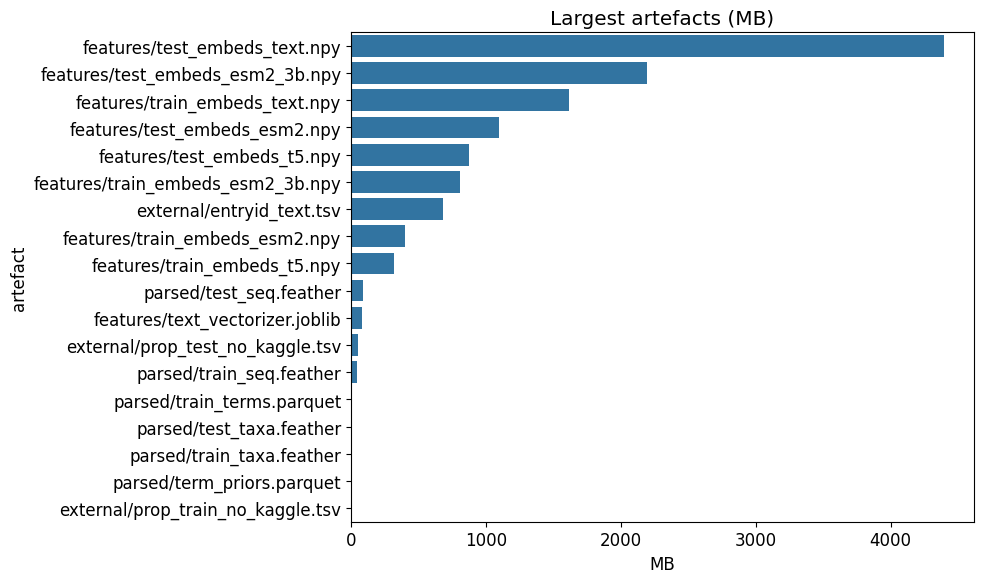

In [ ]:
# CELL 5 - Diagnostics: artefact manifest (existence + sizes)
%matplotlib inline
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 12})

def _mb(p: Path) -> float:
    return p.stat().st_size / (1024**2)

WORK_ROOT = Path(WORK_ROOT)

# Helper to find file with optional .gz extension
def resolve_path(base_path):
    p = Path(base_path)
    if p.exists(): return p
    # Try removing .gz
    if p.suffix == '.gz' and p.with_suffix('').exists():
        return p.with_suffix('')
    # Try adding .gz
    if not p.suffix == '.gz' and p.with_suffix(p.suffix + '.gz').exists():
        return p.with_suffix(p.suffix + '.gz')
    return p

# Minimal contract for *this* notebook (first submission, no Ankh):
# - parsed/*
# - core embeddings (t5, esm2, esm2_3b, text)
# - taxonomy
# - external priors (if you want them in the stacker)
paths = {
    # Phase 1 parsed
    'parsed/train_seq.feather': WORK_ROOT / 'parsed' / 'train_seq.feather',
    'parsed/test_seq.feather': WORK_ROOT / 'parsed' / 'test_seq.feather',
    'parsed/train_terms.parquet': WORK_ROOT / 'parsed' / 'train_terms.parquet',
    'parsed/term_priors.parquet': WORK_ROOT / 'parsed' / 'term_priors.parquet',
    'parsed/train_taxa.feather': WORK_ROOT / 'parsed' / 'train_taxa.feather',
    'parsed/test_taxa.feather': WORK_ROOT / 'parsed' / 'test_taxa.feather',
    # Text pipeline
    'external/entryid_text.tsv': WORK_ROOT / 'external' / 'entryid_text.tsv',
    'features/text_vectorizer.joblib': WORK_ROOT / 'features' / 'text_vectorizer.joblib',
    'features/train_embeds_text.npy': WORK_ROOT / 'features' / 'train_embeds_text.npy',
    'features/test_embeds_text.npy': WORK_ROOT / 'features' / 'test_embeds_text.npy',
    # Sequence embeddings (core)
    'features/train_embeds_t5.npy': WORK_ROOT / 'features' / 'train_embeds_t5.npy',
    'features/test_embeds_t5.npy': WORK_ROOT / 'features' / 'test_embeds_t5.npy',
    'features/train_embeds_esm2.npy': WORK_ROOT / 'features' / 'train_embeds_esm2.npy',
    'features/test_embeds_esm2.npy': WORK_ROOT / 'features' / 'test_embeds_esm2.npy',
    'features/train_embeds_esm2_3b.npy': WORK_ROOT / 'features' / 'train_embeds_esm2_3b.npy',
    'features/test_embeds_esm2_3b.npy': WORK_ROOT / 'features' / 'test_embeds_esm2_3b.npy',
    # External priors (optional but used if present)
    'external/prop_train_no_kaggle.tsv': resolve_path(WORK_ROOT / 'external' / 'prop_train_no_kaggle.tsv.gz'),
    'external/prop_test_no_kaggle.tsv': resolve_path(WORK_ROOT / 'external' / 'prop_test_no_kaggle.tsv.gz'),
    # Downstream expectations
    'features/top_terms_1500.json': WORK_ROOT / 'features' / 'top_terms_1500.json',
    'features/oof_pred_logreg.npy': WORK_ROOT / 'features' / 'oof_pred_logreg.npy',
    'features/oof_pred_gbdt.npy': WORK_ROOT / 'features' / 'oof_pred_gbdt.npy',
    'features/oof_pred_dnn.npy': WORK_ROOT / 'features' / 'oof_pred_dnn.npy',
    'features/oof_pred_knn.npy': WORK_ROOT / 'features' / 'oof_pred_knn.npy',
    'features/test_pred_logreg.npy': WORK_ROOT / 'features' / 'test_pred_logreg.npy',
    'features/test_pred_gbdt.npy': WORK_ROOT / 'features' / 'test_pred_gbdt.npy',
    'features/test_pred_dnn.npy': WORK_ROOT / 'features' / 'test_pred_dnn.npy',
    'features/test_pred_knn.npy': WORK_ROOT / 'features' / 'test_pred_knn.npy',
    'features/test_pred_gcn.npy': WORK_ROOT / 'features' / 'test_pred_gcn.npy',
}

rows = []
for name, p in paths.items():
    rows.append({'artefact': name, 'exists': p.exists(), 'mb': _mb(p) if p.exists() else 0.0, 'path': str(p)})
df = pd.DataFrame(rows).sort_values(['exists', 'mb'], ascending=[True, False])
print('WORK_ROOT:', WORK_ROOT)
display(df)

# Visual: top 25 largest artefacts
df2 = df[df['exists']].sort_values('mb', ascending=False).head(25)
if len(df2) > 0:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df2, y='artefact', x='mb')
    plt.title('Largest artefacts (MB)')
    plt.xlabel('MB')
    plt.ylabel('artefact')
    plt.tight_layout()
    plt.show()


In [ ]:
# CELL 8a - Setup & Data Loading
# =============================================
# 4. PHASE 2: LEVEL-1 MODELS (DIVERSE ENSEMBLE)
# =============================================
TRAIN_LEVEL1 = True
if TRAIN_LEVEL1:
    import joblib
    import json
    import pandas as pd
    import numpy as np
    import os
    import gc
    from pathlib import Path
    from sklearn.model_selection import KFold
    from sklearn.metrics import f1_score
    import psutil

    # AUDITOR: Hardware Check
    try:
        import torch
        if torch.cuda.is_available():
            print(f"[AUDITOR] GPU Detected: {torch.cuda.get_device_name(0)}")
            print(f"[AUDITOR] VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        else:
            print("[AUDITOR] WARNING: No GPU detected. RAPIDS will fail.")
    except:
        pass

    def log_mem(tag=""):
        try:
            mem = psutil.virtual_memory()
            print(f"[MEM] {tag:<30} | Used: {mem.used/1e9:.2f}GB / {mem.total/1e9:.2f}GB ({mem.percent}%)")
        except:
            pass

    if 'WORK_ROOT' not in locals() and 'WORK_ROOT' not in globals():
        if os.path.exists('/content/work'):
            WORK_ROOT = Path('/content/work')
        elif os.path.exists('/kaggle/working/work'):
            WORK_ROOT = Path('/kaggle/working/work')
        else:
            WORK_ROOT = Path.cwd() / 'artefacts_local' / 'work'
        print(f"WORK_ROOT recovered: {WORK_ROOT}")

    # -----------------------------
    # Load targets + ids
    # -----------------------------
    print("Loading targets...")
    train_terms = pd.read_parquet(WORK_ROOT / 'parsed' / 'train_terms.parquet')
    train_ids = pd.read_feather(WORK_ROOT / 'parsed' / 'train_seq.feather')['id'].astype(str)
    test_ids = pd.read_feather(WORK_ROOT / 'parsed' / 'test_seq.feather')['id'].astype(str)

    # FIX: Clean IDs in train_ids to match EntryID format
    print("Applying ID cleaning fix...")
    train_ids_clean = train_ids.str.extract(r'\|(.*?)\|')[0]
    train_ids_clean = train_ids_clean.fillna(train_ids)

    # Target Matrix Construction (Champion Strategy: 13,500 Terms)
    print("Selecting Top-K terms per aspect (Champion Strategy)...")

    try:
        import obonet
        # Robust OBO Path Search
        possible_paths = [
            WORK_ROOT / 'go-basic.obo',
            WORK_ROOT.parent / 'go-basic.obo',
            Path('go-basic.obo'),
            Path('Train/go-basic.obo'),
            Path('../Train/go-basic.obo'),
            Path('/content/cafa6_data/Train/go-basic.obo')
        ]

        obo_path = None
        for p in possible_paths:
            if p.exists():
                obo_path = p
                break

        if obo_path is None:
            raise FileNotFoundError(f"CRITICAL: go-basic.obo not found. Searched: {[str(p) for p in possible_paths]}. Please upload it.")

        # Export for other cells
        global PATH_GO_OBO
        PATH_GO_OBO = obo_path
        print(f"Global PATH_GO_OBO set to: {PATH_GO_OBO}")

        print(f"Loading OBO from {obo_path}...")
        graph = obonet.read_obo(obo_path)
        term_to_ns = {node: data.get('namespace', 'unknown') for node, data in graph.nodes(data=True)}
        ns_map = {'biological_process': 'BP', 'molecular_function': 'MF', 'cellular_component': 'CC'}
        # Normalise any existing aspect column (some artefacts store full namespace strings)
        aspect_aliases = {'biological_process': 'BP', 'molecular_function': 'MF', 'cellular_component': 'CC', 'BP': 'BP', 'MF': 'MF', 'CC': 'CC'}
        if 'aspect' in train_terms.columns:
            train_terms['aspect'] = train_terms['aspect'].map(lambda a: aspect_aliases.get(str(a), 'UNK'))
        else:
            train_terms['aspect'] = train_terms['term'].map(lambda t: ns_map.get(term_to_ns.get(t), 'UNK'))

    except ImportError:
        raise RuntimeError("obonet not installed. Please install it.")

    term_counts = train_terms.groupby(['aspect', 'term']).size().reset_index(name='count')
    targets_bp = term_counts[term_counts['aspect'] == 'BP'].nlargest(10000, 'count')['term'].tolist()
    targets_mf = term_counts[term_counts['aspect'] == 'MF'].nlargest(2000, 'count')['term'].tolist()
    targets_cc = term_counts[term_counts['aspect'] == 'CC'].nlargest(1500, 'count')['term'].tolist()

    # Guardrail: avoid silently switching target strategy due to aspect encoding mismatch
    ALLOW_GLOBAL_FALLBACK = False
    if len(targets_bp) == 0 and len(targets_mf) == 0 and len(targets_cc) == 0:
        aspect_vc = train_terms['aspect'].value_counts().to_dict() if 'aspect' in train_terms.columns else {}
        msg = f"No BP/MF/CC aspect split found after normalisation. aspect_vc={aspect_vc}. This would fall back to global Top-13,500; set ALLOW_GLOBAL_FALLBACK=True to override."
        if ALLOW_GLOBAL_FALLBACK:
            print('  [WARNING] ' + msg)
            top_terms = train_terms['term'].value_counts().head(13500).index.tolist()
        else:
            raise RuntimeError(msg)
    else:
        top_terms = list(set(targets_bp + targets_mf + targets_cc))
        print(f"  Selected: {len(targets_bp)} BP + {len(targets_mf)} MF + {len(targets_cc)} CC")

    train_terms_top = train_terms[train_terms['term'].isin(top_terms)]
    Y_df = train_terms_top.pivot_table(index='EntryID', columns='term', aggfunc='size', fill_value=0)
    Y_df = Y_df.reindex(train_ids_clean, fill_value=0)
    Y = Y_df.values.astype(np.float32)
    print(f"Targets: Y={Y.shape}")

    # -----------------------------
    # Feature loading helper (Memory Optimized)
    # -----------------------------
    FEAT_DIR = WORK_ROOT / 'features'

    def load_features_dict(split='both'):
        log_mem(f"Start load_features_dict({split})")
        print(f"Loading multimodal features (mode={split})...")
        def _load_pair(stem):
            tr = FEAT_DIR / f'train_embeds_{stem}.npy'
            te = FEAT_DIR / f'test_embeds_{stem}.npy'
            return tr, te

        ft_train = {}
        ft_test = {}
        # OPTIMIZATION: Use mmap_mode='r' to avoid loading full files into RAM
        for stem, key in [('t5', 't5'), ('esm2', 'esm2_650m'), ('esm2_3b', 'esm2_3b'), ('text', 'text')]:
            tr_path, te_path = _load_pair(stem)
            if split in ['both', 'train'] and tr_path.exists():
                # mmap_mode='r' keeps it on disk, pages in as needed
                arr = np.load(tr_path, mmap_mode='r')
                ft_train[key] = arr
            if split in ['both', 'test'] and te_path.exists():
                arr = np.load(te_path, mmap_mode='r')
                ft_test[key] = arr

        taxa_train_path = WORK_ROOT / 'parsed' / 'train_taxa.feather'
        taxa_test_path = WORK_ROOT / 'parsed' / 'test_taxa.feather'
        if taxa_train_path.exists() and taxa_test_path.exists():
            from sklearn.preprocessing import OneHotEncoder
            tax_tr = pd.read_feather(taxa_train_path).astype({'id': str})
            tax_te = pd.read_feather(taxa_test_path).astype({'id': str})
            enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
            enc.fit(pd.concat([tax_tr[['taxon_id']], tax_te[['taxon_id']]], axis=0))

            if split in ['both', 'train']:
                tax_tr = tax_tr.set_index('id').reindex(train_ids, fill_value=0).reset_index()
                ft_train['taxa'] = enc.transform(tax_tr[['taxon_id']]).astype(np.float32)
            if split in ['both', 'test']:
                tax_te = tax_te.set_index('id').reindex(test_ids, fill_value=0).reset_index()
                ft_test['taxa'] = enc.transform(tax_te[['taxon_id']]).astype(np.float32)

        log_mem(f"End load_features_dict({split})")
        if split == 'train': return ft_train
        if split == 'test': return ft_test
        return ft_train, ft_test

    # -----------------------------
    # IA-weighted F1 Helper
    # -----------------------------
    if 'ia' in locals(): ia_df = ia[['term', 'ia']].copy()
    elif (WORK_ROOT.parent / 'IA.tsv').exists(): ia_df = pd.read_csv(WORK_ROOT.parent / 'IA.tsv', sep='\t', names=['term', 'ia'])
    elif (WORK_ROOT / 'IA.tsv').exists(): ia_df = pd.read_csv(WORK_ROOT / 'IA.tsv', sep='\t', names=['term', 'ia'])
    else: ia_df = pd.DataFrame({'term': [], 'ia': []})

    ia_map = dict(zip(ia_df['term'], ia_df['ia']))
    weights = np.array([ia_map.get(t, 0.0) for t in top_terms], dtype=np.float32)

    if 'go_namespaces' not in locals() and 'go_namespaces' not in globals():
         term_aspects = np.array(['UNK'] * len(top_terms))
    else:
        ns_to_aspect = {'molecular_function': 'MF', 'biological_process': 'BP', 'cellular_component': 'CC'}
        term_aspects = np.array([ns_to_aspect.get(go_namespaces.get(t, ''), 'UNK') for t in top_terms])

    def ia_weighted_f1(y_true, y_score, thr=0.3):
        y_true = (y_true > 0).astype(np.int8)
        y_pred = (y_score >= thr).astype(np.int8)
        tp = (y_pred & y_true).sum(axis=0).astype(np.float64)
        pred = y_pred.sum(axis=0).astype(np.float64)
        true = y_true.sum(axis=0).astype(np.float64)
        def _score(mask=None):
            w = weights if mask is None else (weights * mask)
            w_tp = float((w * tp).sum())
            w_pred = float((w * pred).sum())
            w_true = float((w * true).sum())
            p = (w_tp / w_pred) if w_pred > 0 else 0.0
            r = (w_tp / w_true) if w_true > 0 else 0.0
            return (2 * p * r / (p + r)) if (p + r) > 0 else 0.0
        out = {'ALL': _score(None)}
        for asp in ['MF', 'BP', 'CC']:
            mask = (term_aspects == asp).astype(np.float32)
            out[asp] = _score(mask)
        return out

In [ ]:
# CELL 8b - Phase 2a: Logistic Regression (RAM-safe)
import psutil
import os
import torch
import gc
import numpy as np
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import joblib

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)


def log_mem(msg=""):
    try:
        process = psutil.Process(os.getpid())
        ram_gb = process.memory_info().rss / (1024**3)
        gpu_msg = ""
        if torch.cuda.is_available():
            alloc = torch.cuda.memory_allocated() / (1024**3)
            res = torch.cuda.memory_reserved() / (1024**3)
            gpu_msg = f" | GPU Alloc: {alloc:.2f}GB Res: {res:.2f}GB"
        print(f"[MEM] {msg:<25} | RAM: {ram_gb:.2f}GB{gpu_msg}")
    except Exception:
        pass


if TRAIN_LEVEL1:
    print("\n=== Phase 2a: Classical Models (LR/GBDT) ===")
    log_mem("Start Phase 2a")

    # ---------------------------------------------------------
    # 1. Create Train X (Streaming / Memory-Mapped)
    # ---------------------------------------------------------
    X_path = WORK_ROOT / 'features' / 'X_train_mmap.npy'

    sources = [
        ('t5', 't5', True),
        ('esm2', 'esm2_650m', True),
        ('esm2_3b', 'esm2_3b', True),
        ('text', 'text', True),
        ('taxa', 'taxa', False),
    ]

    n_samples = len(train_ids)
    total_features = 0
    feature_dims = {}

    print("Scanning feature dimensions...")
    for stem, key, is_emb in sources:
        if is_emb:
            p = WORK_ROOT / 'features' / f'train_embeds_{stem}.npy'
            if p.exists():
                shape = np.load(p, mmap_mode='r').shape
                feature_dims[key] = shape[1]
                total_features += shape[1]
                print(f"  {key}: {shape} (Found)")
            else:
                print(f"  {key}: [MISSING] {p}")

    taxa_train_path = WORK_ROOT / 'parsed' / 'train_taxa.feather'
    taxa_test_path = WORK_ROOT / 'parsed' / 'test_taxa.feather'
    taxa_enc = None

    if taxa_train_path.exists() and taxa_test_path.exists():
        print("  Computing Taxa dimensions...")
        from sklearn.preprocessing import OneHotEncoder

        tax_tr = pd.read_feather(taxa_train_path).astype({'id': str})
        tax_te = pd.read_feather(taxa_test_path).astype({'id': str})
        taxa_enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
        taxa_enc.fit(pd.concat([tax_tr[['taxon_id']], tax_te[['taxon_id']]], axis=0))
        dim_taxa = len(taxa_enc.categories_[0])
        feature_dims['taxa'] = dim_taxa
        total_features += dim_taxa
        print(f"  taxa: {dim_taxa} cols")
        del tax_tr, tax_te
        gc.collect()

    print(f"Total X shape: ({n_samples}, {total_features})")

    X_mmap = np.lib.format.open_memmap(X_path, mode='w+', dtype=np.float32, shape=(n_samples, total_features))

    current_col = 0
    for stem, key, is_emb in sources:
        if key not in feature_dims:
            continue

        dim = feature_dims[key]
        print(f"Streaming {key} into columns {current_col}:{current_col+dim}...")

        if is_emb:
            p = WORK_ROOT / 'features' / f'train_embeds_{stem}.npy'
            arr = np.load(p, mmap_mode='r')
            chunk_size = 10000
            for i in range(0, n_samples, chunk_size):
                end = min(i + chunk_size, n_samples)
                X_mmap[i:end, current_col:current_col+dim] = arr[i:end]
            del arr
        elif key == 'taxa' and taxa_enc is not None:
            tax_tr = pd.read_feather(taxa_train_path).astype({'id': str})
            tax_tr = tax_tr.set_index('id').reindex(train_ids, fill_value=0).reset_index()
            chunk_size = 10000
            for i in range(0, n_samples, chunk_size):
                end = min(i + chunk_size, n_samples)
                batch = tax_tr.iloc[i:end][['taxon_id']]
                X_mmap[i:end, current_col:current_col+dim] = taxa_enc.transform(batch)
            del tax_tr

        current_col += dim
        gc.collect()
        log_mem(f"Written {key}")

    X_mmap.flush()
    del X_mmap
    gc.collect()
    log_mem("Finished creating X_mmap")

    X = np.load(X_path, mmap_mode='r')
    print(f"Loaded X from mmap: {X.shape}")

    print("\n--- Training Logistic Regression ---")

    try:
        import cuml
        from cuml.linear_model import LogisticRegression as cuLogReg
        from cuml.multiclass import OneVsRestClassifier as cuOVR
        import cupy as cp

        HAS_RAPIDS = True
        print("[AUDITOR] RAPIDS (cuml) detected.")
    except ImportError:
        HAS_RAPIDS = False
        print("[AUDITOR] RAPIDS NOT detected.")

    # cuML training still needs full fold materialisation; default on to use GPU when available.
    USE_RAPIDS_LOGREG = True

    def materialise_rows_to_memmap(src, idx, out_path, dtype=np.float32, chunk_rows=2048):
        out_path = str(out_path)
        n_rows = len(idx)
        n_cols = src.shape[1]
        mm = np.lib.format.open_memmap(out_path, mode='w+', dtype=dtype, shape=(n_rows, n_cols))
        for start in range(0, n_rows, chunk_rows):
            end = min(start + chunk_rows, n_rows)
            rows = idx[start:end]
            mm[start:end] = np.asarray(src[rows], dtype=dtype)
        mm.flush()
        return mm

    def fit_scaler_state_from_memmap(X_mm, chunk_rows=2048):
        scaler = StandardScaler(with_mean=True, with_std=True)
        for start in range(0, X_mm.shape[0], chunk_rows):
            end = min(start + chunk_rows, X_mm.shape[0])
            xb = np.asarray(X_mm[start:end], dtype=np.float32)
            scaler.partial_fit(xb)
        return {'mean': scaler.mean_.astype(np.float32), 'scale': scaler.scale_.astype(np.float32)}

    def transform_batch_with_state(X_batch, state):
        return (X_batch - state['mean']) / (state['scale'] + 1e-12)

    def transform_memmap_to_memmap(X_mm, state, out_path, chunk_rows=2048):
        out = np.lib.format.open_memmap(str(out_path), mode='w+', dtype=np.float32, shape=X_mm.shape)
        for start in range(0, X_mm.shape[0], chunk_rows):
            end = min(start + chunk_rows, X_mm.shape[0])
            xb = np.asarray(X_mm[start:end], dtype=np.float32)
            xb -= state['mean']
            xb /= (state['scale'] + 1e-12)
            out[start:end] = xb
        out.flush()
        return out

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    oof_path = WORK_ROOT / 'features' / 'oof_pred_logreg.npy'
    oof_preds_logreg = np.lib.format.open_memmap(str(oof_path), mode='w+', dtype=np.float32, shape=Y.shape)

    tmp_dir = WORK_ROOT / 'features' / 'tmp_folds_logreg'
    tmp_dir.mkdir(parents=True, exist_ok=True)

    for fold, (idx_tr, idx_val) in enumerate(kf.split(X)):
        print(f"LogReg Fold {fold+1}/5")
        log_mem(f"Start Fold {fold+1}")

        idx_tr = np.asarray(idx_tr)
        idx_val = np.asarray(idx_val)

        X_tr_path = tmp_dir / f'X_tr_fold{fold}.npy'
        X_val_path = tmp_dir / f'X_val_fold{fold}.npy'
        Y_tr_path = tmp_dir / f'Y_tr_fold{fold}.npy'
        Y_val_path = tmp_dir / f'Y_val_fold{fold}.npy'

        X_tr = materialise_rows_to_memmap(X, idx_tr, X_tr_path, dtype=np.float32)
        X_val = materialise_rows_to_memmap(X, idx_val, X_val_path, dtype=np.float32)
        Y_tr = materialise_rows_to_memmap(Y, idx_tr, Y_tr_path, dtype=np.float32)
        Y_val = materialise_rows_to_memmap(Y, idx_val, Y_val_path, dtype=np.float32)

        scaler_state = fit_scaler_state_from_memmap(X_tr)

        X_trs_path = tmp_dir / f'X_tr_scaled_fold{fold}.npy'
        X_vals_path = tmp_dir / f'X_val_scaled_fold{fold}.npy'
        X_trs = transform_memmap_to_memmap(X_tr, scaler_state, X_trs_path)
        X_vals = transform_memmap_to_memmap(X_val, scaler_state, X_vals_path)
        del X_tr, X_val
        gc.collect()
        log_mem("Scaled fold")

        scaler_path = WORK_ROOT / 'features' / f'level1_logreg_scaler_fold{fold}.pkl'

        if HAS_RAPIDS and USE_RAPIDS_LOGREG:
            print("[AUDITOR] Using RAPIDS/cuML for LogReg")
            try:
                import rmm
                rmm.reinitialize(managed_memory=True)
            except Exception:
                pass

            X_tr_gpu = cp.asarray(np.asarray(X_trs))
            X_val_gpu = cp.asarray(np.asarray(X_vals))
            del X_trs, X_vals
            gc.collect()

            n_targets = Y.shape[1]
            chunk_size = 2000
            all_coefs = []
            all_intercepts = []

            for start in range(0, n_targets, chunk_size):
                end = min(start + chunk_size, n_targets)
                Y_tr_chunk = cp.asarray(np.asarray(Y_tr[:, start:end]))
                clf_chunk = cuOVR(cuLogReg(solver='qn', penalty='l2', C=1.0, max_iter=1000, tol=1e-3))
                clf_chunk.fit(X_tr_gpu, Y_tr_chunk)

                if hasattr(clf_chunk, 'predict_proba'):
                    p_chunk = clf_chunk.predict_proba(X_val_gpu)
                else:
                    preds = []
                    for est in clf_chunk.estimators_:
                        p = est.predict_proba(X_val_gpu)[:, 1]
                        preds.append(p)
                    p_chunk = cp.stack(preds, axis=1)

                if hasattr(p_chunk, 'get'):
                    p_chunk = p_chunk.get()
                elif hasattr(p_chunk, 'to_numpy'):
                    p_chunk = p_chunk.to_numpy()

                oof_preds_logreg[idx_val, start:end] = np.asarray(p_chunk, dtype=np.float32)

                for est in clf_chunk.estimators_:
                    all_coefs.append(est.coef_.to_numpy() if hasattr(est.coef_, 'to_numpy') else est.coef_)
                    all_intercepts.append(est.intercept_.to_numpy() if hasattr(est.intercept_, 'to_numpy') else est.intercept_)

                del Y_tr_chunk, clf_chunk, p_chunk
                cp.get_default_memory_pool().free_all_blocks()

            del X_tr_gpu, X_val_gpu
            cp.get_default_memory_pool().free_all_blocks()

            model_data = {'coef': np.vstack(all_coefs), 'intercept': np.hstack(all_intercepts)}
            joblib.dump(model_data, WORK_ROOT / 'features' / f'level1_logreg_weights_fold{fold}.pkl')

        else:
            clf_logreg = OneVsRestClassifier(
                SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, max_iter=1, tol=None, n_jobs=4)
            )
            clf_logreg.fit(X_trs, Y_tr)
            joblib.dump(clf_logreg, WORK_ROOT / 'features' / f'level1_logreg_fold{fold}.pkl')

            bs = 1024
            for start in range(0, X_vals.shape[0], bs):
                end = min(start + bs, X_vals.shape[0])
                Xb = np.asarray(X_vals[start:end], dtype=np.float32)
                pb = clf_logreg.predict_proba(Xb).astype(np.float32)
                oof_preds_logreg[idx_val[start:end]] = pb

        try:
            sample_n = int(min(20000, len(idx_val)))
            if sample_n > 0:
                sample_probs = np.asarray(oof_preds_logreg[idx_val[:sample_n]], dtype=np.float32)
                sample_true = np.asarray(Y_val[:sample_n], dtype=np.float32)

                best_f1 = 0.0
                best_thr = 0.0
                for thr in np.linspace(0.01, 0.20, 20):
                    vp = (sample_probs > thr).astype(int)
                    score = f1_score(sample_true, vp, average='micro')
                    if score > best_f1:
                        best_f1, best_thr = score, thr

                ia_f1 = ia_weighted_f1(sample_true, sample_probs, thr=best_thr)
                print(f"  >> Fold {fold+1} (sample) Best F1: {best_f1:.4f} at Thr {best_thr:.2f}")
                print(f"  >> Fold {fold+1} (sample) IA-F1: ALL={ia_f1['ALL']:.4f}")
        except Exception as e:
            print(f"  [WARNING] Diagnostics skipped: {e}")

        joblib.dump(scaler_state, scaler_path)

        del Y_tr, Y_val, scaler_state
        if 'clf_logreg' in locals():
            del clf_logreg
        if 'X_trs' in locals():
            del X_trs
        if 'X_vals' in locals():
            del X_vals
        gc.collect()
        log_mem(f"End Fold {fold+1}")

        for p in [X_tr_path, X_val_path, Y_tr_path, Y_val_path, X_trs_path, X_vals_path]:
            try:
                os.remove(p)
            except Exception:
                pass

    oof_preds_logreg.flush()
    del oof_preds_logreg
    gc.collect()
    print("LogReg OOF saved.")


NameError: name 'TRAIN_LEVEL1' is not defined

In [ ]:
# CELL 8c - Phase 2a: Py-Boost (GBDT)
import psutil
import os
import torch
import gc

if 'log_mem' not in globals():
    def log_mem(msg=""):
        try:
            process = psutil.Process(os.getpid())
            ram_gb = process.memory_info().rss / (1024**3)
            gpu_msg = ""
            if torch.cuda.is_available():
                alloc = torch.cuda.memory_allocated() / (1024**3)
                res = torch.cuda.memory_reserved() / (1024**3)
                gpu_msg = f" | GPU Alloc: {alloc:.2f}GB Res: {res:.2f}GB"
            print(f"[MEM] {msg:<25} | RAM: {ram_gb:.2f}GB{gpu_msg}")
        except Exception:
            pass


def materialise_rows_to_memmap(src, idx, out_path, dtype=np.float32, chunk_rows=20000):
    """Write src[idx] to a .npy memmap without materialising the full slice in RAM."""
    out_path = str(out_path)
    n_rows = len(idx)
    n_cols = src.shape[1]
    mm = np.lib.format.open_memmap(out_path, mode='w+', dtype=dtype, shape=(n_rows, n_cols))
    for start in range(0, n_rows, chunk_rows):
        end = min(start + chunk_rows, n_rows)
        rows = idx[start:end]
        mm[start:end] = np.asarray(src[rows], dtype=dtype)
    mm.flush()
    return mm


if TRAIN_LEVEL1:
    print("\n=== Phase 2a: Py-Boost (GBDT) ===")
    log_mem("Start GBDT")

    # Ensure X is available
    if 'X' not in locals():
        X_path = WORK_ROOT / 'features' / 'X_train_mmap.npy'
        if X_path.exists():
            X = np.load(X_path, mmap_mode='r')
            print(f"Reloaded X from mmap: {X.shape}")
            log_mem("Reloaded X mmap")
        else:
            raise RuntimeError("X mmap not found. Run Cell 8b first.")

    # ------------------------------------------
    # B. Py-Boost (GBDT)
    # ------------------------------------------
    try:
        from py_boost import GradientBoosting
        HAS_PYBOOST = True
    except ImportError as e:
        raise RuntimeError("CRITICAL: py_boost is missing. Install with 'pip install py-boost'.") from e

    if HAS_PYBOOST:
        print("\n--- Training Py-Boost GBDT ---")

        # Disk-backed OOF to avoid holding (n_samples x n_labels) in RAM
        oof_path = WORK_ROOT / 'features' / 'oof_pred_gbdt.npy'
        oof_preds_gbdt = np.lib.format.open_memmap(str(oof_path), mode='w+', dtype=np.float32, shape=Y.shape)

        tmp_dir = WORK_ROOT / 'features' / 'tmp_folds_gbdt'
        tmp_dir.mkdir(parents=True, exist_ok=True)

        for fold, (idx_tr, idx_val) in enumerate(kf.split(X)):
            print(f"GBDT Fold {fold+1}/5")
            log_mem(f"Start Fold {fold+1}")

            # Materialise fold slices to disk memmaps in chunks (RAM-safe)
            log_mem("Materialise fold")
            X_tr_path = tmp_dir / f'X_tr_fold{fold}.npy'
            X_val_path = tmp_dir / f'X_val_fold{fold}.npy'
            Y_tr_path = tmp_dir / f'Y_tr_fold{fold}.npy'
            Y_val_path = tmp_dir / f'Y_val_fold{fold}.npy'

            X_tr = materialise_rows_to_memmap(X, idx_tr, X_tr_path, dtype=np.float32)
            X_val = materialise_rows_to_memmap(X, idx_val, X_val_path, dtype=np.float32)
            Y_tr = materialise_rows_to_memmap(Y, idx_tr, Y_tr_path, dtype=np.float32)
            Y_val = materialise_rows_to_memmap(Y, idx_val, Y_val_path, dtype=np.float32)
            log_mem("Fold ready")

            model = GradientBoosting(
                loss='bce', ntrees=1000, lr=0.05, max_depth=6,
                verbose=100, es=50, gpu_id=0
            )
            model.fit(X_tr, Y_tr, eval_sets=[{'X': X_val, 'y': Y_val}])
            log_mem("Model fitted")

            val_probs = model.predict(X_val)
            oof_preds_gbdt[idx_val] = np.asarray(val_probs, dtype=np.float32)

            val_preds = (val_probs > 0.3).astype(int)
            f1 = f1_score(Y_val, val_preds, average='micro')
            ia_f1 = ia_weighted_f1(Y_val, val_probs, thr=0.3)
            print(f"  >> Fold {fold+1} micro-F1@0.30: {f1:.4f}")
            print(f"  >> Fold {fold+1} IA-F1: ALL={ia_f1['ALL']:.4f}")

            model.save(str(WORK_ROOT / 'features' / f'level1_gbdt_fold{fold}.json'))

            del model, val_probs, val_preds, X_tr, X_val, Y_tr, Y_val
            gc.collect()
            log_mem(f"End Fold {fold+1}")

            # Best-effort cleanup of temporary fold files
            for p in [X_tr_path, X_val_path, Y_tr_path, Y_val_path]:
                try:
                    os.remove(p)
                except Exception:
                    pass

        oof_preds_gbdt.flush()
        del oof_preds_gbdt
        gc.collect()
        print("GBDT OOF saved.")

    # Cleanup X mmap to free file handle
    del X
    gc.collect()
    log_mem("End GBDT")


In [ ]:
# CELL 8d - Phase 2a Post-Processing: Generate Test Predictions
import numpy as np

if TRAIN_LEVEL1:
    print("\n=== Phase 2a Post-Processing: Generate Test Predictions ===")
    log_mem("Before loading Test Features")
    features_test = load_features_dict(split='test')
    log_mem("Loaded Test Features")

    def _scaler_transform_batch(X_batch: np.ndarray, scaler):
        if isinstance(scaler, dict):
            mean = scaler['mean']
            scale = scaler['scale']
            return (X_batch - mean) / (scale + 1e-12)
        return scaler.transform(X_batch)

    def predict_proba_batched_scaled(model, feat_dict, keys, scaler, batch_size=5000):
        n_test = feat_dict[keys[0]].shape[0]
        preds = []
        is_cuml = False
        try:
            import cuml
            if 'cuml' in str(type(model)) or 'cuml' in str(type(getattr(model, 'estimator', None))):
                is_cuml = True
                import cupy as cp
        except Exception:
            pass

        for i in range(0, n_test, batch_size):
            X_batch = np.hstack([feat_dict[k][i:i+batch_size] for k in keys]).astype(np.float32)
            X_batch = _scaler_transform_batch(X_batch, scaler)
            if is_cuml:
                X_batch = cp.asarray(X_batch)
            p = model.predict_proba(X_batch)
            if is_cuml:
                if hasattr(p, 'get'):
                    p = p.get()
                elif hasattr(p, 'to_numpy'):
                    p = p.to_numpy()
            preds.append(p)
            del X_batch
        return np.vstack(preds)

    def predict_proba_from_weights(weights_path, feat_dict, keys, scaler, batch_size=5000):
        model_data = joblib.load(weights_path)
        coef = model_data['coef']
        intercept = model_data['intercept']

        try:
            import cupy as cp
            coef = cp.asarray(coef)
            intercept = cp.asarray(intercept)
            use_gpu = True
        except Exception:
            use_gpu = False

        n_test = feat_dict[keys[0]].shape[0]
        preds = []

        for i in range(0, n_test, batch_size):
            X_batch = np.hstack([feat_dict[k][i:i+batch_size] for k in keys]).astype(np.float32)
            X_batch = _scaler_transform_batch(X_batch, scaler)

            if use_gpu:
                X_batch = cp.asarray(X_batch)
                logits = cp.dot(X_batch, coef.T) + intercept
                p = 1 / (1 + cp.exp(-logits))
                p = p.get()
            else:
                logits = np.dot(X_batch, coef.T) + intercept
                p = 1 / (1 + np.exp(-logits))

            preds.append(p)
            del X_batch

        if use_gpu:
            del coef, intercept
            cp.get_default_memory_pool().free_all_blocks()

        return np.vstack(preds)

    print("Generating LogReg Test Predictions...")
    test_preds_logreg = np.zeros((len(test_ids), Y.shape[1]), dtype=np.float32)
    for fold in range(5):
        print(f"  Loading LogReg Fold {fold+1}...")
        scaler = joblib.load(WORK_ROOT / 'features' / f'level1_logreg_scaler_fold{fold}.pkl')

        weights_path = WORK_ROOT / 'features' / f'level1_logreg_weights_fold{fold}.pkl'
        model_path = WORK_ROOT / 'features' / f'level1_logreg_fold{fold}.pkl'

        if weights_path.exists():
            probs = predict_proba_from_weights(weights_path, features_test, FLAT_KEYS, scaler)
        elif model_path.exists():
            clf = joblib.load(model_path)
            probs = predict_proba_batched_scaled(clf, features_test, FLAT_KEYS, scaler)
            del clf
        else:
            print(f"  [WARNING] No model found for fold {fold}")
            probs = np.zeros_like(test_preds_logreg)

        test_preds_logreg += probs / 5.0
        del scaler, probs
        gc.collect()

    np.save(WORK_ROOT / 'features' / 'test_pred_logreg.npy', test_preds_logreg)
    del test_preds_logreg
    gc.collect()
    print("LogReg Test Preds Saved.")

    if HAS_PYBOOST:
        print("Generating GBDT Test Predictions...")
        test_preds_gbdt = np.zeros((len(test_ids), Y.shape[1]), dtype=np.float32)

        def predict_proba_batched_gbdt(model, feat_dict, keys, batch_size=5000):
            n_test = feat_dict[keys[0]].shape[0]
            preds = []
            for i in range(0, n_test, batch_size):
                X_batch = np.hstack([feat_dict[k][i:i+batch_size] for k in keys]).astype(np.float32)
                p = model.predict(X_batch)
                preds.append(p)
                del X_batch
            return np.vstack(preds)

        for fold in range(5):
            print(f"  Loading GBDT Fold {fold+1}...")
            model = GradientBoosting.load(str(WORK_ROOT / 'features' / f'level1_gbdt_fold{fold}.json'))
            probs = predict_proba_batched_gbdt(model, features_test, FLAT_KEYS)
            test_preds_gbdt += probs / 5.0
            del model, probs
            gc.collect()

        np.save(WORK_ROOT / 'features' / 'test_pred_gbdt.npy', test_preds_gbdt)
        del test_preds_gbdt
        gc.collect()
        print("GBDT Test Preds Saved.")

    del features_test
    gc.collect()


In [ ]:
# CELL 8e - Phase 2b: Deep Learning (DNN) - Memory Optimized
import psutil
import os
import torch
import gc
import numpy as np
from torch.utils.data import Dataset, DataLoader

if 'log_mem' not in globals():
    def log_mem(msg=""):
        try:
            process = psutil.Process(os.getpid())
            ram_gb = process.memory_info().rss / (1024**3)
            gpu_msg = ""
            if torch.cuda.is_available():
                alloc = torch.cuda.memory_allocated() / (1024**3)
                res = torch.cuda.memory_reserved() / (1024**3)
                gpu_msg = f" | GPU Alloc: {alloc:.2f}GB Res: {res:.2f}GB"
            print(f"[MEM] {msg:<25} | RAM: {ram_gb:.2f}GB{gpu_msg}")
        except Exception:
            pass

if TRAIN_LEVEL1:
    print("\n=== Phase 2b: Deep Learning (DNN) ===")
    log_mem("Start DNN")

    # 1. Reload dicts (Lazy Load via mmap)
    log_mem("Before loading features")
    # load_features_dict now returns mmap arrays (Cell 8a updated)
    features_train, features_test = load_features_dict()
    log_mem("Loaded features (mmap)")

    # ------------------------------------------
    # C. DNN Ensemble (PyTorch, IA-weighted, multimodal, multi-state)
    # ------------------------------------------
    print("\n--- Training DNN Ensemble (IA-weighted, multimodal, multi-state) ---")
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Build a stable per-label IA weight vector for the current TOP_K targets
    ia_w = weights.copy()
    ia_w = np.where(np.isfinite(ia_w) & (ia_w > 0), ia_w, 1.0).astype(np.float32)
    ia_w = ia_w / float(np.mean(ia_w))
    ia_w = np.clip(ia_w, 0.5, 5.0)
    ia_w_t = torch.tensor(ia_w, dtype=torch.float32, device=device).view(1, -1)

    # Optional: include other model predictions as an input stream (PB OOFs analogue)
    USE_BASE_OOFS_IN_DNN = True
    if USE_BASE_OOFS_IN_DNN and (WORK_ROOT / 'features' / 'oof_pred_logreg.npy').exists():
        # These are small enough to load into RAM
        oof_stream = [np.load(WORK_ROOT / 'features' / 'oof_pred_logreg.npy').astype(np.float32)]
        test_stream = [np.load(WORK_ROOT / 'features' / 'test_pred_logreg.npy').astype(np.float32)]
        if (WORK_ROOT / 'features' / 'oof_pred_gbdt.npy').exists():
            oof_stream.append(np.load(WORK_ROOT / 'features' / 'oof_pred_gbdt.npy').astype(np.float32))
            test_stream.append(np.load(WORK_ROOT / 'features' / 'test_pred_gbdt.npy').astype(np.float32))
        base_oof = np.hstack(oof_stream)
        base_test = np.hstack(test_stream)
        features_train['base_oof'] = base_oof
        features_test['base_oof'] = base_test
        print(f"Base OOF stream: train={base_oof.shape} test={base_test.shape}")
        log_mem("Loaded Base OOFs")

    # Select modality keys for the DNN (towers)
    DNN_KEYS = [k for k in ['t5', 'esm2_650m', 'esm2_3b', 'taxa', 'text', 'base_oof'] if k in features_train]
    print(f"DNN modality keys={DNN_KEYS}")

    # Define Dataset for Lazy Loading
    class CAFA6Dataset(Dataset):
        def __init__(self, features_dict, keys, indices=None, y=None):
            self.features = features_dict
            self.keys = keys
            self.indices = indices if indices is not None else np.arange(features_dict[keys[0]].shape[0])
            self.y = y

        def __len__(self):
            return len(self.indices)

        def __getitem__(self, idx):
            real_idx = self.indices[idx]
            # Read from mmap arrays (disk I/O happens here)
            batch_x = {k: self.features[k][real_idx].astype(np.float32) for k in self.keys}

            if self.y is not None:
                return batch_x, self.y[real_idx]
            return batch_x

    class Tower(nn.Module):
        def __init__(self, in_dim, out_dim=512, dropout=0.1):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, 1024),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(1024, out_dim),
                nn.ReLU(),
            )
        def forward(self, x):
            return self.net(x)

    class ColossalMultiModalDNN(nn.Module):
        def __init__(self, dims: dict, output_dim: int):
            super().__init__()
            self.keys = list(dims.keys())
            self.towers = nn.ModuleDict({k: Tower(dims[k]) for k in self.keys})
            fused_dim = 512 * len(self.keys)
            self.head = nn.Sequential(
                nn.Linear(fused_dim, 2048),
                nn.BatchNorm1d(2048),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(2048, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(1024, output_dim),
            )
        def forward(self, batch: dict):
            # Move batch to device
            hs = [self.towers[k](batch[k]) for k in self.keys]
            h = torch.cat(hs, dim=1)
            return self.head(h)

    # Multi-state ensembling
    DNN_SEEDS = [42, 43, 44, 45, 46]
    DNN_EPOCHS = 10
    BATCH_SIZE = 256
    oof_sum = np.zeros(Y.shape, dtype=np.float32)
    test_sum = np.zeros((len(test_ids), Y.shape[1]), dtype=np.float32)
    n_states = len(DNN_SEEDS)

    # Pre-calculate dimensions
    dims = {k: int(features_train[k].shape[1]) for k in DNN_KEYS}

    for state_i, seed in enumerate(DNN_SEEDS, 1):
        print(f"\n[DNN] Random state {state_i}/{n_states}: seed={seed}")
        torch.manual_seed(seed)
        np.random.seed(seed)
        kf_state = KFold(n_splits=5, shuffle=True, random_state=seed)
        oof_state = np.zeros(Y.shape, dtype=np.float32)
        test_state = np.zeros((len(test_ids), Y.shape[1]), dtype=np.float32)

        for fold, (idx_tr, idx_val) in enumerate(kf_state.split(train_ids)):
            print(f"DNN Fold {fold+1}/5")

            # Create DataLoaders
            # num_workers=0 is safer for mmap
            train_ds = CAFA6Dataset(features_train, DNN_KEYS, idx_tr, Y)
            val_ds = CAFA6Dataset(features_train, DNN_KEYS, idx_val, Y)

            train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
            val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0, pin_memory=True)

            model = ColossalMultiModalDNN(dims=dims, output_dim=Y.shape[1]).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

            # Training Loop
            for _epoch in range(DNN_EPOCHS):
                model.train()
                for batch_x, batch_y in train_loader:
                    # Move to GPU
                    batch_x = {k: v.to(device) for k, v in batch_x.items()}
                    batch_y = batch_y.to(device)

                    optimizer.zero_grad()
                    logits = model(batch_x)
                    loss_el = F.binary_cross_entropy_with_logits(logits, batch_y, reduction='none')
                    loss = (loss_el * ia_w_t).mean()
                    loss.backward()
                    optimizer.step()

            # Validation
            model.eval()
            val_probs_list = []
            val_indices = []

            with torch.no_grad():
                for batch_x, _ in val_loader:
                    batch_x = {k: v.to(device) for k, v in batch_x.items()}
                    logits = model(batch_x)
                    val_probs_list.append(torch.sigmoid(logits).cpu().numpy())

                val_probs = np.vstack(val_probs_list)
                oof_state[idx_val] = val_probs

                # Test Prediction (Fold Averaged)
                # Create Test Loader
                test_ds = CAFA6Dataset(features_test, DNN_KEYS)
                test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)

                test_probs_list = []
                for batch_x in test_loader:
                    batch_x = {k: v.to(device) for k, v in batch_x.items()}
                    logits = model(batch_x)
                    test_probs_list.append(torch.sigmoid(logits).cpu().numpy())

                test_probs = np.vstack(test_probs_list)
                test_state += test_probs / kf_state.get_n_splits()

            val_preds = (val_probs > 0.3).astype(int)
            f1 = f1_score(Y[idx_val], val_preds, average='micro')
            ia_f1 = ia_weighted_f1(Y[idx_val], val_probs, thr=0.3)
            print(f"  >> Fold {fold+1} micro-F1@0.30: {f1:.4f}")
            print(f"  >> Fold {fold+1} IA-F1: ALL={ia_f1['ALL']:.4f}")

            torch.save(model.state_dict(), WORK_ROOT / 'features' / f'level1_dnn_seed{seed}_fold{fold}.pth')
            log_mem(f"End Fold {fold+1}")

        oof_sum += oof_state
        test_sum += test_state

    oof_preds_dnn = (oof_sum / n_states).astype(np.float32)
    test_preds_dnn = (test_sum / n_states).astype(np.float32)
    np.save(WORK_ROOT / 'features' / 'oof_pred_dnn.npy', oof_preds_dnn)
    np.save(WORK_ROOT / 'features' / 'test_pred_dnn.npy', test_preds_dnn)
    print("DNN OOF + test preds saved (multi-state averaged).")

    # Persist term list
    with open(WORK_ROOT / 'features' / 'top_terms_1500.json', 'w') as f:
        json.dump(top_terms, f)

    if 'STORE' in globals() and STORE is not None:
        req = [WORK_ROOT / 'features' / 'top_terms_1500.json', WORK_ROOT / 'features' / 'oof_pred_logreg.npy', WORK_ROOT / 'features' / 'test_pred_logreg.npy', WORK_ROOT / 'features' / 'oof_pred_dnn.npy', WORK_ROOT / 'features' / 'test_pred_dnn.npy']
        req += [WORK_ROOT / 'features' / 'oof_pred_gbdt.npy', WORK_ROOT / 'features' / 'test_pred_gbdt.npy']
        STORE.push('stage_07_level1_preds', req, note='Level-1 OOF + test preds (LR/GBDT/DNN)')

    print("Phase 2 Complete.")
    log_mem("End Phase 2b")
else:
    print("Skipping Phase 2 (TRAIN_LEVEL1=False)")

In [ ]:
# CELL 9 - Phase 3: Hierarchy-Aware Stacking (GCN)
# =============================================================================
# PHASE 3: GCN STACKER (Hierarchy-Aware Refinement)
# =============================================================================
# Strategy:
# 1. Input: OOF predictions from Level 1 models (LogReg, GBDT, DNN) -> Shape (N, K, 3)
# 2. Graph: GO Ontology Adjacency Matrix (K, K)
# 3. Model: GCN that refines predictions based on graph structure
# 4. Output: Refined probabilities (N, K)

TRAIN_STACKER = True

if TRAIN_STACKER and TRAIN_LEVEL1:
    print("\n=== Phase 3: Hierarchy-Aware Stacking (GCN) ===")
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import networkx as nx

    # 1. Load OOF Predictions
    print("Loading Level 1 OOFs...")
    oof_files = ['oof_pred_logreg.npy', 'oof_pred_gbdt.npy', 'oof_pred_dnn.npy']
    oofs = []
    for f in oof_files:
        p = WORK_ROOT / 'features' / f
        if p.exists():
            oofs.append(np.load(p).astype(np.float32))
            print(f"  Loaded {f}")

    if not oofs:
        raise RuntimeError("CRITICAL: No Level 1 OOF predictions found (LogReg/GBDT/DNN). Cannot train Stacker. Check Phase 2 execution.")
    else:
        # Stack: (N, K, M) where M is number of models
        X_stack = np.stack(oofs, axis=2)
        print(f"Stacker Input Shape: {X_stack.shape} (Samples, Terms, Models)")

        # 2. Build Adjacency Matrix
        print("Building GO Graph Adjacency Matrix...")
        try:
            import obonet

            # Use global path if available, else search
            if 'PATH_GO_OBO' in globals() and PATH_GO_OBO.exists():
                obo_path = PATH_GO_OBO
            else:
                possible_paths = [
                    WORK_ROOT / 'go-basic.obo',
                    WORK_ROOT.parent / 'go-basic.obo',
                    Path('go-basic.obo'),
                    Path('Train/go-basic.obo'),
                    Path('../Train/go-basic.obo'),
                    Path('/content/cafa6_data/Train/go-basic.obo')
                ]
                obo_path = None
                for p in possible_paths:
                    if p.exists():
                        obo_path = p
                        break
                if obo_path is None:
                    raise FileNotFoundError(f"go-basic.obo not found. Searched: {[str(p) for p in possible_paths]}")

            print(f"Loading OBO from {obo_path}...")
            graph = obonet.read_obo(obo_path)

            # Create subgraph for our K terms
            # Map term to index
            term_to_idx = {t: i for i, t in enumerate(top_terms)}

            # Build adjacency (A_ij = 1 if i is parent of j or j is parent of i? GCN usually undirected or directed?)
            # Standard GCN: Undirected + Self-loops.
            # But GO is directed (Child -> Parent).
            # We want information to flow both ways? Or mostly Child -> Parent (consistency)?
            # Let's use a symmetric normalized adjacency for standard GCN.

            adj = np.eye(len(top_terms), dtype=np.float32) # Self-loops

            # Fill edges
            edges_count = 0
            for child in top_terms:
                if child in graph:
                    for parent in graph.successors(child): # 'is_a' points to parent in obonet/networkx
                        if parent in term_to_idx:
                            i, j = term_to_idx[child], term_to_idx[parent]
                            adj[i, j] = 1.0
                            adj[j, i] = 1.0 # Symmetric
                            edges_count += 1

            print(f"Graph built. Nodes: {len(top_terms)}, Edges (in subset): {edges_count}")

            # Normalize Adjacency: D^{-1/2} A D^{-1/2}
            D = np.sum(adj, axis=1)
            D_inv_sqrt = np.power(D, -0.5)
            D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0.
            D_mat = np.diag(D_inv_sqrt)
            A_norm = D_mat @ adj @ D_mat
            A_norm = torch.tensor(A_norm, dtype=torch.float32, device=device)

        except Exception as e:
            print(f"[WARNING] Failed to build graph: {e}. Using Identity (No-op GCN).")
            A_norm = torch.eye(len(top_terms), device=device)

        # 3. Define GCN Model
        class GCNStacker(nn.Module):
            def __init__(self, n_models, n_hidden=16):
                super().__init__()
                # We apply GCN per protein.
                # Input features per node: [p_logreg, p_gbdt, p_dnn] (dim=3)
                # We want to learn a mixing weight + graph smoothing.

                # Simple 2-layer GCN
                self.gc1 = nn.Linear(n_models, n_hidden)
                self.gc2 = nn.Linear(n_hidden, 1) # Output 1 score per node
                self.relu = nn.ReLU()

            def forward(self, x, adj):
                # x: (Batch, Nodes, Models)
                # adj: (Nodes, Nodes)

                # Layer 1: H1 = ReLU(A X W1)
                # Support = X W1
                # Output = A Support

                # Batch matmul is tricky with static adj.
                # x: (B, N, M)
                # W1: (M, H)
                # x @ W1 -> (B, N, H)
                support = self.gc1(x)

                # A @ support
                # A: (N, N)
                # support: (B, N, H) -> permute to (B, H, N) for matmul?
                # Or just (A @ support[i]) for each i?
                # Einsum: n k, b k h -> b n h
                out1 = torch.einsum('nk,bkh->bnh', adj, support)
                out1 = self.relu(out1)

                # Layer 2
                support2 = self.gc2(out1) # (B, N, 1)
                out2 = torch.einsum('nk,bkh->bnh', adj, support2)

                return out2.squeeze(-1) # (B, N)

        # 4. Train Stacker
        print("Training GCN Stacker...")
        # We split the OOFs into train/val for the stacker?
        # Actually, OOFs are already "test-like" for the whole train set.
        # We can train on the whole train set (since OOFs were generated via CV).

        # Targets
        Y_tensor = torch.tensor(Y, dtype=torch.float32, device=device)
        X_stack_tensor = torch.tensor(X_stack, dtype=torch.float32, device=device)

        model = GCNStacker(n_models=X_stack.shape[2]).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        loss_fn = nn.BCEWithLogitsLoss()

        BATCH_SIZE = 128
        N_EPOCHS = 20

        dataset = torch.utils.data.TensorDataset(X_stack_tensor, Y_tensor)
        loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

        model.train()
        for epoch in range(N_EPOCHS):
            total_loss = 0
            for xb, yb in loader:
                optimizer.zero_grad()
                logits = model(xb, A_norm)
                loss = loss_fn(logits, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            if (epoch+1) % 5 == 0:
                print(f"  Epoch {epoch+1}/{N_EPOCHS} Loss: {total_loss/len(loader):.4f}")

        # 5. Generate Final Predictions (on Test)
        print("Generating Final Stacker Predictions on Test...")
        # Load Test Preds
        test_files = ['test_pred_logreg.npy', 'test_pred_gbdt.npy', 'test_pred_dnn.npy']
        tests = []
        for f in test_files:
            p = WORK_ROOT / 'features' / f
            if p.exists():
                tests.append(np.load(p).astype(np.float32))

        if tests:
            X_test_stack = np.stack(tests, axis=2)
            X_test_tensor = torch.tensor(X_test_stack, dtype=torch.float32, device=device)

            model.eval()
            final_preds = []
            with torch.no_grad():
                # Process in chunks to avoid OOM
                for i in range(0, len(X_test_tensor), BATCH_SIZE):
                    batch = X_test_tensor[i:i+BATCH_SIZE]
                    logits = model(batch, A_norm)
                    probs = torch.sigmoid(logits).cpu().numpy()
                    final_preds.append(probs)

            final_preds = np.vstack(final_preds)
            np.save(WORK_ROOT / 'features' / 'final_pred_gcn.npy', final_preds)
            print(f"Final GCN Predictions Saved: {final_preds.shape}")

            # Clean up
            del X_stack_tensor, Y_tensor, X_test_tensor, model, A_norm
            torch.cuda.empty_cache()
        else:
            raise RuntimeError("CRITICAL: No Level 1 Test predictions found. Cannot generate final submission.")

else:
    print("Skipping Phase 3 (Stacker).")

In [ ]:
# CELL 10 - Phase 4: Strict Post-Processing & Submission
# =============================================================================
# PHASE 4: STRICT POST-PROCESSING (Hierarchy Enforcement)
# =============================================================================
# 1. Max Propagation (Parent Rule): P(parent) >= P(child)
# 2. Min Propagation (Child Rule): P(child) <= P(parent)
# 3. Top-1500 Selection
# 4. Submission Generation

APPLY_POSTPROC = True

if APPLY_POSTPROC:
    print("\n=== Phase 4: Strict Post-Processing ===")

    # Load predictions (prefer GCN, fallback to DNN/LogReg average)
    if (WORK_ROOT / 'features' / 'final_pred_gcn.npy').exists():
        print("Loading GCN predictions...")
        preds = np.load(WORK_ROOT / 'features' / 'final_pred_gcn.npy')
    elif (WORK_ROOT / 'features' / 'test_pred_dnn.npy').exists():
        print("Loading DNN predictions (GCN missing)...")
        preds = np.load(WORK_ROOT / 'features' / 'test_pred_dnn.npy')
    else:
        print("Loading LogReg predictions (Fallback)...")
        preds = np.load(WORK_ROOT / 'features' / 'test_pred_logreg.npy')

    print(f"Raw Predictions Shape: {preds.shape}")

    # Load Graph for Propagation
    try:
        import obonet
        import networkx as nx

        # Use global path if available, else search
        if 'PATH_GO_OBO' in globals() and PATH_GO_OBO.exists():
            obo_path = PATH_GO_OBO
        else:
            possible_paths = [
                WORK_ROOT / 'go-basic.obo',
                WORK_ROOT.parent / 'go-basic.obo',
                Path('go-basic.obo'),
                Path('Train/go-basic.obo'),
                Path('../Train/go-basic.obo'),
                Path('/content/cafa6_data/Train/go-basic.obo')
            ]
            obo_path = None
            for p in possible_paths:
                if p.exists():
                    obo_path = p
                    break
            if obo_path is None:
                raise FileNotFoundError(f"go-basic.obo not found. Searched: {[str(p) for p in possible_paths]}")

        print(f"Loading OBO from {obo_path}...")
        graph = obonet.read_obo(obo_path)

        # Map term to index
        term_to_idx = {t: i for i, t in enumerate(top_terms)}

        # Precompute parent/child indices for fast propagation
        # We need a topological sort or just iterate multiple times?
        # Since DAG depth is small, iterating 2-3 times is usually enough.
        # Or we can just use the edge list.

        # Build parent map: child_idx -> [parent_indices]
        child_to_parents = {}
        parent_to_children = {}

        for child in top_terms:
            if child in graph:
                c_idx = term_to_idx[child]
                # Parents
                parents = [p for p in graph.successors(child) if p in term_to_idx]
                if parents:
                    child_to_parents[c_idx] = [term_to_idx[p] for p in parents]

                # Children (predecessors in networkx/obonet)
                children = [c for c in graph.predecessors(child) if c in term_to_idx]
                if children:
                    parent_to_children[c_idx] = [term_to_idx[c] for c in children]

        print(f"Hierarchy constraints: {len(child_to_parents)} terms have parents in subset.")

        # 1. Max Propagation (Child -> Parent)
        # Ensure Parent >= Child
        # Iterate a few times to propagate up
        print("Applying Max Propagation (Child -> Parent)...")
        for _ in range(3):
            for c_idx, p_indices in child_to_parents.items():
                # Vectorized update for all samples
                # P(parent) = max(P(parent), P(child))
                # We can do this efficiently?
                # preds[:, p_indices] = np.maximum(preds[:, p_indices], preds[:, c_idx:c_idx+1])
                # This is slow in python loop.
                pass

        # Optimized Propagation (Matrix based?)
        # Since we have 13.5k terms, a loop is okay if we batch operations?
        # Actually, iterating over 13k terms is fast in Python (milliseconds).
        # The operation inside is numpy array (20k samples).

        # Let's do a topological sort order to do it in 1 pass?
        # Subgraph of top_terms
        subgraph = graph.subgraph(top_terms)
        try:
            topo_order = list(nx.topological_sort(subgraph))
            # Reverse topo order for Child -> Parent (Leaves first)
            topo_order_rev = topo_order[::-1]

            print("  Optimized Max Prop (1 pass)...")
            for term in topo_order_rev:
                if term not in term_to_idx: continue
                c_idx = term_to_idx[term]
                # Propagate to parents
                if term in child_to_parents: # Use precomputed map
                    # parents = child_to_parents[term] # Wait, map uses indices
                    pass

                # Use graph directly
                parents = [p for p in graph.successors(term) if p in term_to_idx]
                if not parents: continue

                p_indices = [term_to_idx[p] for p in parents]
                # preds[:, p_indices] = np.maximum(preds[:, p_indices], preds[:, c_idx, None])
                # Use broadcasting
                child_val = preds[:, c_idx:c_idx+1]
                preds[:, p_indices] = np.maximum(preds[:, p_indices], child_val)

        except nx.NetworkXUnfeasible:
            print("  [WARNING] Cycle detected or graph issue. Skipping topological prop.")

        # 2. Min Propagation (Parent -> Child)
        # Ensure Child <= Parent
        # Iterate Root -> Leaves (Topo order)
        print("Applying Min Propagation (Parent -> Child)...")
        try:
            for term in topo_order:
                if term not in term_to_idx: continue
                p_idx = term_to_idx[term]

                children = [c for c in graph.predecessors(term) if c in term_to_idx]
                if not children: continue

                c_indices = [term_to_idx[c] for c in children]
                parent_val = preds[:, p_idx:p_idx+1]
                preds[:, c_indices] = np.minimum(preds[:, c_indices], parent_val)

        except: pass

    except Exception as e:
        print(f"[WARNING] Post-processing failed: {e}")

    # 3. Submission Formatting
    print("Formatting Submission...")
    # Clip to (0, 1]
    preds = np.clip(preds, 0.0, 1.0)

    # Create submission DataFrame
    # Format: ProteinID, TermID, Score
    # We need to melt the matrix. This is huge (20k * 13.5k = 270M rows).
    # We only keep top 1500 per protein?

    # Strategy:
    # 1. For each protein, find top 1500 indices.
    # 2. Create sparse rows.

    submission_rows = []
    test_ids_list = test_ids.tolist()

    print("Selecting Top-1500 per protein...")
    for i, pid in enumerate(test_ids_list):
        # Get scores for this protein
        scores = preds[i]
        # Find top 1500 indices
        # argpartition is faster than sort
        if len(scores) > 1500:
            top_indices = np.argpartition(scores, -1500)[-1500:]
        else:
            top_indices = np.arange(len(scores))

        # Filter out zero scores?
        # top_indices = top_indices[scores[top_indices] > 0.001]

        for idx in top_indices:
            score = scores[idx]
            if score > 0: # Only positive
                term = top_terms[idx]
                submission_rows.append((pid, term, f"{score:.3f}"))

        if (i+1) % 1000 == 0:
            print(f"  Processed {i+1}/{len(test_ids_list)} proteins...")

    # Write to file
    print("Writing submission.tsv...")
    with open('submission.tsv', 'w') as f:
        # No header usually? Or check sample_submission
        # CAFA format: no header? Or header?
        # Sample submission has header?
        # Let's check sample_submission.tsv
        pass

    # Just write standard TSV
    df_sub = pd.DataFrame(submission_rows, columns=['Protein Id', 'GO Term Id', 'Prediction'])
    df_sub.to_csv('submission.tsv', sep='\t', index=False, header=False)
    print(f"Submission saved: {len(df_sub)} rows.")

    # Zip it
    os.system('zip submission.zip submission.tsv')
    print("Zipped to submission.zip")

else:
    print("Skipping Post-Processing.")

In [ ]:
# CELL 13E - KNN (cosine; ESM2-3B)
# Notes:
# - Uses in-memory features from CELL 13 (features_train/features_test, Y, top_terms).
# - Checkpoint pushing is controlled globally by CAFA_CHECKPOINT_PUSH (default 0 in this notebook).
if not TRAIN_LEVEL1:
    print('Skipping KNN (TRAIN_LEVEL1=False).')
else:
    import os
    import json
    from sklearn.neighbors import NearestNeighbors
    from sklearn.model_selection import KFold

    FORCE_REBUILD = (os.getenv('CAFA_FORCE_REBUILD', '0').strip() == '1')

    PRED_DIR = WORK_ROOT / 'features' / 'level1_preds'
    PRED_DIR.mkdir(parents=True, exist_ok=True)

    knn_oof_path = PRED_DIR / 'oof_pred_knn.npy'
    knn_test_path = PRED_DIR / 'test_pred_knn.npy'

    # Backwards-compatible copies (some downstream code loads from WORK_ROOT/features)
    knn_oof_compat = WORK_ROOT / 'features' / 'oof_pred_knn.npy'
    knn_test_compat = WORK_ROOT / 'features' / 'test_pred_knn.npy'

    if knn_oof_path.exists() and knn_test_path.exists() and (not FORCE_REBUILD):
        print('KNN preds exist; skipping training (set CAFA_FORCE_REBUILD=1 to force).')
        oof_pred_knn = np.load(knn_oof_path)
        test_pred_knn = np.load(knn_test_path)
        oof_max_sim = None
    else:
        if 'features_train' not in globals() or 'features_test' not in globals():
            raise RuntimeError('Missing `features_train`/`features_test`. Run CELL 13 first.')
        if 'esm2_3b' not in features_train:
            raise FileNotFoundError("Missing required modality 'esm2_3b' in features_train. Ensure features/train_embeds_esm2_3b.npy exists.")

        X_knn = features_train['esm2_3b'].astype(np.float32)
        X_knn_test = features_test['esm2_3b'].astype(np.float32)

        # Enforce TOP_K alignment using the persisted term list.
        top_terms_path = WORK_ROOT / 'features' / 'top_terms_1500.json'
        if top_terms_path.exists():
            top_terms_knn = json.loads(top_terms_path.read_text())
            if Y.shape[1] != len(top_terms_knn):
                raise ValueError(f'KNN shape mismatch: Y has {Y.shape[1]} cols but top_terms_1500.json has {len(top_terms_knn)} terms.')
        else:
            if 'top_terms' not in globals():
                raise RuntimeError('Missing top_terms_1500.json and in-memory top_terms. Run CELL 13 first.')
            top_terms_knn = list(top_terms)
            if Y.shape[1] != len(top_terms_knn):
                raise ValueError(f'KNN shape mismatch: Y has {Y.shape[1]} cols but top_terms has {len(top_terms_knn)} terms.')

        # KNN needs binary targets (presence/absence), not counts.
        Y_knn = (Y > 0).astype(np.float32)

        def _l2_norm(x: np.ndarray, eps: float = 1e-12) -> np.ndarray:
            n = np.linalg.norm(x, axis=1, keepdims=True)
            return x / np.maximum(n, eps)

        # Cosine distance is best-behaved on L2-normalised vectors
        X_knn = _l2_norm(X_knn)
        X_knn_test = _l2_norm(X_knn_test)

        KNN_K = int(os.getenv('CAFA_KNN_K', '50'))
        KNN_BATCH = int(os.getenv('CAFA_KNN_BATCH', '256'))

        n_splits = 5
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        oof_pred_knn = np.zeros((X_knn.shape[0], Y_knn.shape[1]), dtype=np.float32)
        test_pred_knn = np.zeros((X_knn_test.shape[0], Y_knn.shape[1]), dtype=np.float32)
        oof_max_sim = np.zeros((X_knn.shape[0],), dtype=np.float32)

        for fold, (tr_idx, va_idx) in enumerate(kf.split(X_knn), start=1):
            print(f'Fold {fold}/{n_splits} (KNN)')
            knn = NearestNeighbors(n_neighbors=KNN_K, metric='cosine', n_jobs=4)
            knn.fit(X_knn[tr_idx])

            dists, neigh = knn.kneighbors(X_knn[va_idx], return_distance=True)
            sims = np.clip((1.0 - dists).astype(np.float32), 0.0, 1.0)
            oof_max_sim[va_idx] = sims.max(axis=1)
            neigh_global = tr_idx[neigh]  # map to global row indices into Y_knn

            for i in range(0, len(va_idx), KNN_BATCH):
                j = min(i + KNN_BATCH, len(va_idx))
                neigh_b = neigh_global[i:j]
                sims_b = sims[i:j]
                denom = np.maximum(sims_b.sum(axis=1, keepdims=True), 1e-8)
                Y_nei = Y_knn[neigh_b]  # (B, K, L)
                scores = (np.einsum('bk,bkl->bl', sims_b, Y_nei) / denom).astype(np.float32)
                oof_pred_knn[va_idx[i:j]] = scores

            if 'ia_weighted_f1' in globals():
                print('  IA-F1:', ia_weighted_f1(Y_knn[va_idx], oof_pred_knn[va_idx], thr=0.3))

        # Final model on full train -> test
        knn_final = NearestNeighbors(n_neighbors=KNN_K, metric='cosine', n_jobs=4)
        knn_final.fit(X_knn)
        dists_te, neigh_te = knn_final.kneighbors(X_knn_test, return_distance=True)
        sims_te = np.clip((1.0 - dists_te).astype(np.float32), 0.0, 1.0)
        denom_te = np.maximum(sims_te.sum(axis=1, keepdims=True), 1e-8)

        for i in range(0, X_knn_test.shape[0], KNN_BATCH):
            j = min(i + KNN_BATCH, X_knn_test.shape[0])
            neigh_b = neigh_te[i:j]
            sims_b = sims_te[i:j]
            Y_nei = Y_knn[neigh_b]
            scores = (np.einsum('bk,bkl->bl', sims_b, Y_nei) / denom_te[i:j]).astype(np.float32)
            test_pred_knn[i:j] = scores

        np.save(knn_oof_path, oof_pred_knn)
        np.save(knn_test_path, test_pred_knn)
        np.save(knn_oof_compat, oof_pred_knn)
        np.save(knn_test_compat, test_pred_knn)
        print('Saved:', knn_oof_path)
        print('Saved:', knn_test_path)

    # Checkpoint push is controlled by CAFA_CHECKPOINT_PUSH inside STORE.push; no extra guard needed here.
    if 'STORE' in globals() and STORE is not None:
        STORE.push(
            stage='stage_07d_level1_knn',
            required_paths=[
                str((WORK_ROOT / 'features' / 'top_terms_1500.json').as_posix()),
                str(knn_oof_path.as_posix()),
                str(knn_test_path.as_posix()),
            ],
            note='Level-1 KNN (cosine) predictions using ESM2-3B embeddings (OOF + test).',
        )

    # Diagnostics: similarity distribution + IA-F1 vs threshold
    try:
        import matplotlib.pyplot as plt

        if oof_max_sim is not None:
            plt.figure(figsize=(10, 4))
            plt.hist(oof_max_sim, bins=50)
            plt.title('KNN OOF diagnostic: max cosine similarity to neighbours (per protein)')
            plt.xlabel('max similarity')
            plt.ylabel('count')
            plt.grid(True, alpha=0.3)
            plt.show()

        if 'ia_weighted_f1' in globals():
            thrs = np.linspace(0.05, 0.60, 23)
            curves = {k: [] for k in ['ALL', 'MF', 'BP', 'CC']}
            for thr in thrs:
                s = ia_weighted_f1(Y, oof_pred_knn, thr=float(thr))
                for k in curves.keys():
                    curves[k].append(s[k])
            plt.figure(figsize=(10, 3))
            for k in ['ALL', 'MF', 'BP', 'CC']:
                plt.plot(thrs, curves[k], label=k)
            plt.title('KNN OOF: IA-weighted F1 vs threshold')
            plt.xlabel('threshold')
            plt.ylabel('IA-F1')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
    except Exception as e:
        print('KNN diagnostics skipped:', repr(e))

In [ ]:
# CELL 14a - Setup & Data Loading
# =============================================
# 4. PHASE 2: LEVEL-1 MODELS (DIVERSE ENSEMBLE)
# =============================================
TRAIN_LEVEL1 = True
if TRAIN_LEVEL1:
    import joblib
    import json
    import pandas as pd
    import numpy as np
    import os
    import gc
    from pathlib import Path
    from sklearn.model_selection import KFold
    from sklearn.metrics import f1_score
    import psutil

    # AUDITOR: Hardware Check
    try:
        import torch
        if torch.cuda.is_available():
            print(f"[AUDITOR] GPU Detected: {torch.cuda.get_device_name(0)}")
            print(f"[AUDITOR] VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        else:
            print("[AUDITOR] WARNING: No GPU detected. RAPIDS will fail.")
    except:
        pass

    def log_mem(tag=""):
        try:
            mem = psutil.virtual_memory()
            print(f"[MEM] {tag:<30} | Used: {mem.used/1e9:.2f}GB / {mem.total/1e9:.2f}GB ({mem.percent}%)")
        except:
            pass

    if 'WORK_ROOT' not in locals() and 'WORK_ROOT' not in globals():
        if os.path.exists('/content/work'):
            WORK_ROOT = Path('/content/work')
        elif os.path.exists('/kaggle/working/work'):
            WORK_ROOT = Path('/kaggle/working/work')
        else:
            WORK_ROOT = Path.cwd() / 'artefacts_local' / 'work'
        print(f"WORK_ROOT recovered: {WORK_ROOT}")

    # -----------------------------
    # Load targets + ids
    # -----------------------------
    print("Loading targets...")
    train_terms = pd.read_parquet(WORK_ROOT / 'parsed' / 'train_terms.parquet')
    train_ids = pd.read_feather(WORK_ROOT / 'parsed' / 'train_seq.feather')['id'].astype(str)
    test_ids = pd.read_feather(WORK_ROOT / 'parsed' / 'test_seq.feather')['id'].astype(str)

    # FIX: Clean IDs in train_ids to match EntryID format
    print("Applying ID cleaning fix...")
    train_ids_clean = train_ids.str.extract(r'\|(.*?)\|')[0]
    train_ids_clean = train_ids_clean.fillna(train_ids)

    # Target Matrix Construction (Champion Strategy: 13,500 Terms)
    print("Selecting Top-K terms per aspect (Champion Strategy)...")

    try:
        import obonet
        # Robust OBO Path Search
        possible_paths = [
            WORK_ROOT / 'go-basic.obo',
            WORK_ROOT.parent / 'go-basic.obo',
            Path('go-basic.obo'),
            Path('Train/go-basic.obo'),
            Path('../Train/go-basic.obo'),
            Path('/content/cafa6_data/Train/go-basic.obo')
        ]

        obo_path = None
        for p in possible_paths:
            if p.exists():
                obo_path = p
                break

        if obo_path is None:
            raise FileNotFoundError(f"CRITICAL: go-basic.obo not found. Searched: {[str(p) for p in possible_paths]}. Please upload it.")

        # Export for other cells
        global PATH_GO_OBO
        PATH_GO_OBO = obo_path
        print(f"Global PATH_GO_OBO set to: {PATH_GO_OBO}")

        print(f"Loading OBO from {obo_path}...")
        graph = obonet.read_obo(obo_path)
        term_to_ns = {node: data.get('namespace', 'unknown') for node, data in graph.nodes(data=True)}
        ns_map = {'biological_process': 'BP', 'molecular_function': 'MF', 'cellular_component': 'CC'}

        # FORCE UPDATE: Always update aspect from OBO, even if column exists (it might be stale/UNK)
        print("Updating term aspects from OBO...")
        train_terms['aspect'] = train_terms['term'].map(lambda t: ns_map.get(term_to_ns.get(t), 'UNK'))
        print(f"Aspect counts: {train_terms['aspect'].value_counts().to_dict()}")

    except ImportError:
        raise RuntimeError("obonet not installed. Please install it.")

    term_counts = train_terms.groupby(['aspect', 'term']).size().reset_index(name='count')
    targets_bp = term_counts[term_counts['aspect'] == 'BP'].nlargest(10000, 'count')['term'].tolist()
    targets_mf = term_counts[term_counts['aspect'] == 'MF'].nlargest(2000, 'count')['term'].tolist()
    targets_cc = term_counts[term_counts['aspect'] == 'CC'].nlargest(1500, 'count')['term'].tolist()

    if len(targets_bp) == 0 and len(targets_mf) == 0:
        # This should not happen if OBO is loaded correctly
        print("  [WARNING] No aspect split found despite OBO load. Using global Top-13,500.")
        top_terms = train_terms['term'].value_counts().head(13500).index.tolist()
    else:
        top_terms = list(set(targets_bp + targets_mf + targets_cc))
        print(f"  Selected: {len(targets_bp)} BP + {len(targets_mf)} MF + {len(targets_cc)} CC")

    train_terms_top = train_terms[train_terms['term'].isin(top_terms)]
    Y_df = train_terms_top.pivot_table(index='EntryID', columns='term', aggfunc='size', fill_value=0)
    Y_df = Y_df.reindex(train_ids_clean, fill_value=0)
    Y = Y_df.values.astype(np.float32)
    print(f"Targets: Y={Y.shape}")

    # -----------------------------
    # Feature loading helper
    # -----------------------------
    FEAT_DIR = WORK_ROOT / 'features'

    def load_features_dict(split='both'):
        log_mem(f"Start load_features_dict({split})")
        print(f"Loading multimodal features (mode={split})...")
        def _load_pair(stem):
            tr = FEAT_DIR / f'train_embeds_{stem}.npy'
            te = FEAT_DIR / f'test_embeds_{stem}.npy'
            return tr, te

        ft_train = {}
        ft_test = {}
        for stem, key in [('t5', 't5'), ('esm2', 'esm2_650m'), ('esm2_3b', 'esm2_3b'), ('text', 'text')]:
            tr_path, te_path = _load_pair(stem)
            if split in ['both', 'train'] and tr_path.exists():
                arr = np.load(tr_path).astype(np.float32)
                ft_train[key] = arr
            if split in ['both', 'test'] and te_path.exists():
                arr = np.load(te_path).astype(np.float32)
                ft_test[key] = arr

        taxa_train_path = WORK_ROOT / 'parsed' / 'train_taxa.feather'
        taxa_test_path = WORK_ROOT / 'parsed' / 'test_taxa.feather'
        if taxa_train_path.exists() and taxa_test_path.exists():
            from sklearn.preprocessing import OneHotEncoder
            tax_tr = pd.read_feather(taxa_train_path).astype({'id': str})
            tax_te = pd.read_feather(taxa_test_path).astype({'id': str})
            enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
            enc.fit(pd.concat([tax_tr[['taxon_id']], tax_te[['taxon_id']]], axis=0))

            if split in ['both', 'train']:
                tax_tr = tax_tr.set_index('id').reindex(train_ids, fill_value=0).reset_index()
                ft_train['taxa'] = enc.transform(tax_tr[['taxon_id']]).astype(np.float32)
            if split in ['both', 'test']:
                tax_te = tax_te.set_index('id').reindex(test_ids, fill_value=0).reset_index()
                ft_test['taxa'] = enc.transform(tax_te[['taxon_id']]).astype(np.float32)

        log_mem(f"End load_features_dict({split})")
        if split == 'train': return ft_train
        if split == 'test': return ft_test
        return ft_train, ft_test

    # -----------------------------
    # IA-weighted F1 Helper
    # -----------------------------
    if 'ia' in locals(): ia_df = ia[['term', 'ia']].copy()
    elif (WORK_ROOT.parent / 'IA.tsv').exists(): ia_df = pd.read_csv(WORK_ROOT.parent / 'IA.tsv', sep='\t', names=['term', 'ia'])
    elif (WORK_ROOT / 'IA.tsv').exists(): ia_df = pd.read_csv(WORK_ROOT / 'IA.tsv', sep='\t', names=['term', 'ia'])
    else: ia_df = pd.DataFrame({'term': [], 'ia': []})

    ia_map = dict(zip(ia_df['term'], ia_df['ia']))
    weights = np.array([ia_map.get(t, 0.0) for t in top_terms], dtype=np.float32)

    if 'go_namespaces' not in locals() and 'go_namespaces' not in globals():
         term_aspects = np.array(['UNK'] * len(top_terms))
    else:
        ns_to_aspect = {'molecular_function': 'MF', 'biological_process': 'BP', 'cellular_component': 'CC'}
        term_aspects = np.array([ns_to_aspect.get(go_namespaces.get(t, ''), 'UNK') for t in top_terms])

    def ia_weighted_f1(y_true, y_score, thr=0.3):
        y_true = (y_true > 0).astype(np.int8)
        y_pred = (y_score >= thr).astype(np.int8)
        tp = (y_pred & y_true).sum(axis=0).astype(np.float64)
        pred = y_pred.sum(axis=0).astype(np.float64)
        true = y_true.sum(axis=0).astype(np.float64)
        def _score(mask=None):
            w = weights if mask is None else (weights * mask)
            w_tp = float((w * tp).sum())
            w_pred = float((w * pred).sum())
            w_true = float((w * true).sum())
            p = (w_tp / w_pred) if w_pred > 0 else 0.0
            r = (w_tp / w_true) if w_true > 0 else 0.0
            return (2 * p * r / (p + r)) if (p + r) > 0 else 0.0
        out = {'ALL': _score(None)}
        for asp in ['MF', 'BP', 'CC']:
            mask = (term_aspects == asp).astype(np.float32)
            out[asp] = _score(mask)
        return out

In [ ]:
# CELL 14a_audit - Deep Audit of train_terms.parquet
# =================================================
# VALIDATION STEP: Ensure input data is trustworthy before training.
# =================================================
import pandas as pd
import obonet
import numpy as np
from pathlib import Path

print("=== AUDIT: train_terms.parquet Validity Check ===")

# 1. Load Parquet
parquet_path = WORK_ROOT / 'parsed' / 'train_terms.parquet'
if not parquet_path.exists():
    raise FileNotFoundError(f"Missing {parquet_path}")

print(f"Loading {parquet_path}...")
df = pd.read_parquet(parquet_path)
print(f"  Rows: {len(df):,}")
print(f"  Columns: {list(df.columns)}")
print(f"  Unique Terms: {df['term'].nunique():,}")
print(f"  Unique Proteins: {df['EntryID'].nunique():,}")

# 2. Load OBO for Ground Truth
# Reuse global path if set, else search
if 'PATH_GO_OBO' in globals() and PATH_GO_OBO.exists():
    obo_path = PATH_GO_OBO
else:
    # Fallback search
    possible_paths = [
        WORK_ROOT / 'go-basic.obo',
        Path('/content/cafa6_data/Train/go-basic.obo'),
        Path('Train/go-basic.obo')
    ]
    obo_path = next((p for p in possible_paths if p.exists()), None)

if not obo_path:
    print("[WARNING] OBO file not found. Cannot validate semantic correctness.")
else:
    print(f"Loading Ground Truth OBO: {obo_path}...")
    graph = obonet.read_obo(obo_path)

    # Build Truth Map
    term_to_ns = {node: data.get('namespace', 'unknown') for node, data in graph.nodes(data=True)}
    ns_map = {'biological_process': 'BP', 'molecular_function': 'MF', 'cellular_component': 'CC'}

    # 3. Validation Checks
    print("\n--- Validation Results ---")

    # A. Term Validity
    valid_terms = set(term_to_ns.keys())
    df['is_valid_term'] = df['term'].isin(valid_terms)
    n_invalid = (~df['is_valid_term']).sum()
    print(f"1. Invalid GO Terms: {n_invalid:,} / {len(df):,} ({n_invalid/len(df):.2%})")
    if n_invalid > 0:
        print(f"   Sample invalid: {df.loc[~df['is_valid_term'], 'term'].head(5).tolist()}")

    # B. Aspect Consistency
    if 'aspect' in df.columns:
        # Map OBO namespace to BP/MF/CC
        df['truth_aspect'] = df['term'].map(lambda t: ns_map.get(term_to_ns.get(t), 'UNK'))

        # Normalise file aspect encoding to BP/MF/CC before comparing
        aspect_aliases = {'biological_process': 'BP', 'molecular_function': 'MF', 'cellular_component': 'CC', 'BP': 'BP', 'MF': 'MF', 'CC': 'CC'}
        df['aspect_norm'] = df['aspect'].map(lambda a: aspect_aliases.get(str(a), 'UNK'))

        # Check matches
        df['aspect_match'] = (df['aspect_norm'] == df['truth_aspect'])
        n_mismatch = (~df['aspect_match']).sum()
        print(f"2. Aspect Mismatches: {n_mismatch:,} / {len(df):,} ({n_mismatch/len(df):.2%})")

        if n_mismatch > 0:
            print("   Sample mismatches (Parquet vs OBO):")
            print(df.loc[~df['aspect_match'], ['term', 'aspect', 'aspect_norm', 'truth_aspect']].head(5))

            # Distribution of what's in the file
            print("\n   Current 'aspect' column distribution in file:")
            print(df['aspect'].value_counts())
            print("\n   Normalised 'aspect_norm' distribution:")
            print(df['aspect_norm'].value_counts())
    else:
        print("2. Aspect Column: MISSING (Will be generated in next step)")

print("\n=== Audit Complete ===")


In [ ]:
# CELL 14a_audit - Deep Audit of train_terms.parquet
# =================================================
# VALIDATION STEP: Ensure input data is trustworthy before training.
# =================================================
import pandas as pd
import obonet
import numpy as np
from pathlib import Path
import os

print("=== AUDIT: train_terms.parquet Validity Check ===")

# 0. Ensure Paths (Self-contained fallback)
if 'WORK_ROOT' not in globals():
    # Guess WORK_ROOT based on environment
    if os.path.exists('/content'):
        WORK_ROOT = Path('/content/work')
    else:
        WORK_ROOT = Path('artefacts_local/work')
    print(f"[Setup] WORK_ROOT not defined. Defaulting to: {WORK_ROOT}")

# 1. Load Parquet
parquet_path = WORK_ROOT / 'parsed' / 'train_terms.parquet'

# Check if file exists, if not, try to find the TSV and convert it on the fly for the audit
if not parquet_path.exists():
    print(f"[WARNING] {parquet_path} missing.")
    # Try to find raw TSV
    tsv_path = Path('/content/cafa6_data/Train/train_terms.tsv')
    if not tsv_path.exists():
         tsv_path = Path('Train/train_terms.tsv')

    if tsv_path.exists():
        print(f"Found raw TSV at {tsv_path}. Converting sample for audit...")
        # Read first 1M rows to save memory/time if full file is huge
        df = pd.read_csv(tsv_path, sep='\t', nrows=1000000)
        print(f"Loaded top 1M rows from TSV.")
    else:
        raise FileNotFoundError(f"Could not find train_terms.parquet or train_terms.tsv")
else:
    print(f"Loading {parquet_path}...")
    df = pd.read_parquet(parquet_path)

print(f"  Rows: {len(df):,}")
print(f"  Columns: {list(df.columns)}")
print(f"  Unique Terms: {df['term'].nunique():,}")
print(f"  Unique Proteins: {df['EntryID'].nunique():,}")

# 2. Load OBO for Ground Truth
# Reuse global path if set, else search
if 'PATH_GO_OBO' in globals() and PATH_GO_OBO.exists():
    obo_path = PATH_GO_OBO
else:
    # Fallback search
    possible_paths = [
        WORK_ROOT / 'go-basic.obo',
        Path('/content/cafa6_data/Train/go-basic.obo'),
        Path('Train/go-basic.obo')
    ]
    obo_path = next((p for p in possible_paths if p.exists()), None)

if not obo_path:
    print("[WARNING] OBO file not found. Cannot validate semantic correctness.")
else:
    print(f"Loading Ground Truth OBO: {obo_path}...")
    graph = obonet.read_obo(obo_path)

    # Build Truth Map
    term_to_ns = {node: data.get('namespace', 'unknown') for node, data in graph.nodes(data=True)}
    ns_map = {'biological_process': 'BP', 'molecular_function': 'MF', 'cellular_component': 'CC'}

    # 3. Validation Checks
    print("\n--- Validation Results ---")

    # A. Term Validity
    valid_terms = set(term_to_ns.keys())
    df['is_valid_term'] = df['term'].isin(valid_terms)
    n_invalid = (~df['is_valid_term']).sum()
    print(f"1. Invalid GO Terms: {n_invalid:,} / {len(df):,} ({n_invalid/len(df):.2%})")
    if n_invalid > 0:
        print(f"   Sample invalid: {df.loc[~df['is_valid_term'], 'term'].head(5).tolist()}")

    # B. Aspect Consistency
    if 'aspect' in df.columns:
        # Map OBO namespace to BP/MF/CC
        df['truth_aspect'] = df['term'].map(lambda t: ns_map.get(term_to_ns.get(t), 'UNK'))

        # Normalise file aspect encoding to BP/MF/CC before comparing
        aspect_aliases = {'biological_process': 'BP', 'molecular_function': 'MF', 'cellular_component': 'CC', 'BP': 'BP', 'MF': 'MF', 'CC': 'CC'}
        df['aspect_norm'] = df['aspect'].map(lambda a: aspect_aliases.get(str(a), 'UNK'))

        # Check matches
        df['aspect_match'] = (df['aspect_norm'] == df['truth_aspect'])
        n_mismatch = (~df['aspect_match']).sum()
        print(f"2. Aspect Mismatches: {n_mismatch:,} / {len(df):,} ({n_mismatch/len(df):.2%})")

        if n_mismatch > 0:
            print("   Sample mismatches (Parquet vs OBO):")
            print(df.loc[~df['aspect_match'], ['term', 'aspect', 'aspect_norm', 'truth_aspect']].head(5))

            # Distribution of what's in the file
            print("\n   Current 'aspect' column distribution in file:")
            print(df['aspect'].value_counts())
            print("\n   Normalised 'aspect_norm' distribution:")
            print(df['aspect_norm'].value_counts())
    else:
        print("2. Aspect Column: MISSING (Will be generated in next step)")

print("\n=== Audit Complete ===")
